In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
plt.rcParams['figure.figsize'] = 10,8

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
pd.max_rows = 200
pd.max_columns = 200

Loading the data from CSV file...

In [0]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Home Credit Default/application_train.csv')

Lets take a look at the features and their data types..

In [0]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   SK_ID_CURR                    int64  
 1   TARGET                        int64  
 2   NAME_CONTRACT_TYPE            object 
 3   CODE_GENDER                   object 
 4   FLAG_OWN_CAR                  object 
 5   FLAG_OWN_REALTY               object 
 6   CNT_CHILDREN                  int64  
 7   AMT_INCOME_TOTAL              float64
 8   AMT_CREDIT                    float64
 9   AMT_ANNUITY                   float64
 10  AMT_GOODS_PRICE               float64
 11  NAME_TYPE_SUITE               object 
 12  NAME_INCOME_TYPE              object 
 13  NAME_EDUCATION_TYPE           object 
 14  NAME_FAMILY_STATUS            object 
 15  NAME_HOUSING_TYPE             object 
 16  REGION_POPULATION_RELATIVE    float64
 17  DAYS_BIRTH                    int64  
 18  DAYS_EMPLOYED          

In [0]:
df.shape

(307511, 122)

The SK_ID_CURR represents a unique ID for each application in HOME CREDIT database. This feature will not be used for modelling, it will be used later for submission and accuracy testing. Hence, lets drop this feature from the dataset as of now, andd store it separately.

In [7]:
sk_id_curr = df['SK_ID_CURR']
df = df.drop('SK_ID_CURR', axis=1)
df.shape

(307511, 121)

lets look at the mean, median ad other statistics of the data

In [0]:
df.describe()

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,...,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,...,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,12.061091,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.152665,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.502130,5.143927e-01,0.510853,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,0.149725,0.226282,0.231894,...,0.149213,0.225897,0.231625,0.067169,0.101954,0.108607,0.008651,0.028236,0.102547,1.422245,0.143421,1.405292,0.100049,-962.858788,0.000042,0.710023,0.000081,0.015115,0.088055,0.000192,0.081376,0.003896,0.000023,0.003912,0.000007,0.003525,0.002936,0.00121,0.009928,0.000267,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,3522.886321,1509.450419,11.944812,0.001803,0.384280,0.399526,0.043164,0.449521,0.231307,0.910682,0.509034,0.502737,3.265832,0.122126,0.219526,0.197499,0.268444,0.421124,0.383817,0.211062,1.910602e-01,0.194844,0.10824,0.082438,0.059223,0.113280,0.076036,0.134576,0.100049,0.144641,0.161380,...,0.100368,0.145067,0.161934,0.082167,0.093642,0.112260,0.047415,0.070166,0.107462,2.400989,0.446698,2.379803,0.362291,826.808487,0.006502,0.453752,0.009016,0.122010,0.283376,0.013850,0.273412,0.062295,0.004771,0.062424,0.002550,0.059268,0.054110,0.03476,

Lets divide the dataset into good and bad loans and see the summary of both.

In [0]:
df_bad = df[df['TARGET'] == 1]
df_good = df[df['TARGET']==0]

In [0]:
df_bad.describe()

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,...,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,24825.0,24825.000000,2.482500e+04,2.482500e+04,24825.000000,2.480400e+04,24825.000000,24825.000000,24825.000000,24825.000000,24825.000000,7576.000000,24825.0,24825.000000,24825.000000,24825.000000,24825.000000,24825.000000,24825.000000,24825.000000,24825.000000,24825.000000,24825.000000,24825.000000,24825.000000,24825.000000,24825.00000,24825.000000,10054.000000,24773.000000,19148.000000,10540.000000,8787.000000,11017.000000,7074.000000,6402.000000,9910.000000,10614.000000,10761.000000,6817.00000,...,10614.000000,10761.000000,6817.000000,8721.000000,6703.000000,10714.000000,6498.000000,9495.000000,11119.000000,24789.000000,24789.000000,24789.000000,24789.000000,24825.000000,24825.000000,24825.000000,24825.0,24825.000000,24825.000000,24825.000000,24825.000000,24825.000000,24825.0,24825.000000,24825.0,24825.000000,24825.000000,24825.000000,24825.000000,24825.000000,24825.000000,24825.000000,24825.000000,24825.000000,20533.000000,20533.000000,20533.000000,20533.000000,20533.000000,20533.000000
mean,1.0,0.463807,1.656118e+05,5.577785e+05,26481.744290,4.889724e+05,0.019131,-14884.828077,42394.675448,-4487.127009,-2732.099617,13.668691,1.0,0.879517,0.237825,0.998187,0.244955,0.055347,2.181269,2.153635,2.134824,11.797100,0.017442,0.055911,0.042538,0.118389,0.30292,0.221672,0.386968,0.410935,0.390717,0.105766,0.081548,0.975634,0.743231,0.039444,0.062036,0.142707,0.203021,0.21196,...,0.142227,0.202692,0.211754,0.063793,0.093478,0.095206,0.008171,0.024796,0.089769,1.496147,0.191980,1.477672,0.138247,-808.796818,0.000161,0.777925,0.0,0.014985,0.060705,0.000121,0.073958,0.002981,0.0,0.003021,0.0,0.001208,0.001208,0.000443,0.006042,0.000081,0.005720,0.000483,0.000524,0.000564,0.006672,0.008036,0.034919,0.227926,0.259923,2.028783
std,0.0,0.756903,7.466770e+05,3.464332e+05,12450.676999,3.116365e+05,0.011905,4192.844583,119484.634253,3299.650241,1516.975313,12.499074,0.0,0.325532,0.425760,0.042538,0.430069,0.228662,0.951327,0.505052,0.499909,3.284299,0.130914,0.229755,0.201817,0.323074,0.45953,0.415380,0.204729,0.213107,0.205810,0.100959,0.074289,0.069148,0.112389,0.066716,0.119132,0.098134,0.134414,0.14873,...,0.098443,0.134705,0.148931,0.081093,0.088873,0.101968,0.046690,0.063137,0.098530,2.378438,0.516524,2.355908,0.427645,758.090713,0.012693,0.415649,0.0,0.121495,0.238793,0.010993,0.261707,0.054517,0.0,0.054883,0.0,0.034743,0.034743,0.021046,0.077499,0.008976,0.075416,0.021981,0.022878,0.023741,0.084926,0.106682,0.203941,0.745116,0.643789,1.934063
min,1.0,0.000000,2.565000e+04,4.500000e+04,2722.500000,4.

The mean income of the people who faced difficulty in repayment is 165612 USD per year. The min and max incomes are USD 25,650 and USD 117,000,000 per year. Hence there is a great variablity in the income of the applicants.

In [0]:
df_good.describe()

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,...,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,282686.0,282686.000000,2.826860e+05,2.826860e+05,282674.000000,2.824290e+05,282686.000000,282686.000000,282686.000000,282686.000000,282686.000000,97006.000000,282686.000000,282686.000000,282686.000000,282686.000000,282686.000000,282686.000000,282684.000000,282686.000000,282686.000000,282686.000000,282686.000000,282686.000000,282686.000000,282686.000000,282686.000000,282686.000000,124079.000000,2.820780e+05,227398.000000,140910.000000,118781.000000,146487.000000,95949.000000,86244.000000,133710.000000,142069.000000,143730.000000,92052.000000,...,142069.000000,143730.000000,92052.000000,116200.000000,90609.000000,142447.000000,87499.000000,128334.000000,147961.000000,281701.000000,281701.000000,281701.000000,281701.000000,282685.000000,282686.000000,282686.000000,282686.000000,282686.000000,282686.000000,282686.000000,282686.000000,282686.000000,282686.000000,282686.000000,282686.000000,282686.000000,282686.000000,282686.000000,282686.000000,282686.000000,282686.000000,282686.000000,282686.000000,282686.000000,245459.000000,245459.000000,245459.000000,245459.000000,245459.000000,245459.000000
mean,0.0,0.412946,1.690777e+05,6.026483e+05,27163.623349,5.427368e+05,0.021021,-16138.176397,65696.146123,-5029.941065,-3017.219788,11.935540,0.999996,0.814653,0.195991,0.998129,0.284238,0.056840,2.150154,2.043578,2.022449,12.086807,0.014942,0.050317,0.040494,0.074641,0.224090,0.175856,0.511461,5.234787e-01,0.520969,0.118314,0.088952,0.977893,0.753153,0.045005,0.080194,0.150249,0.228023,0.233370,...,0.149735,0.227634,0.233097,0.067422,0.102582,0.109615,0.008687,0.028490,0.103507,1.415742,0.139148,1.398923,0.096688,-976.388294,0.000032,0.704060,0.000088,0.015126,0.090457,0.000198,0.082027,0.003976,0.000025,0.003990,0.000007,0.003729,0.003088,0.001277,0.010269,0.000283,0.008341,0.000605,0.000506,0.000315,0.006380,0.006914,0.034315,0.270697,0.265939,1.889199
std,0.0,0.718843,1.104763e+05,4.068459e+05,14658.307178,3.737855e+05,0.013978,4364.200856,142877.810161,3538.464478,1506.614090,11.891359,0.001881,0.388579,0.396963,0.043219,0.451051,0.231538,0.906984,0.508422,0.501971,3.263173,0.121323,0.218599,0.197114,0.262812,0.416982,0.380698,0.208804,1.862767e-01,0.190465,0.108715,0.082987,0.058406,0.113316,0.076669,0.135567,0.100171,0.145228,0.162181,...,0.100492,0.145665,0.162759,0.082242,0.093956,0.112933,0.047468,0.070652,0.108043,2.402858,0.439768,2.381793,0.355771,831.210739,0.005642,0.456465,0.009404,0.122056,0.286836,0.014073,0.274407,0.062931,0.004976,0.063043,0.002660,0.060948,0.055486,0.035713,0.100816,0.

The mean income of the people who were repaying loan properly is 169,077 USD per year. The min and max incomes are USD 25,650 and USD 11,700,000 per year. The max income of rejected applicants is much lower than that of accepted applicants.

At the outset lets calculate the ratio of good and bad loans.

In [0]:
target = df['TARGET']

In [11]:
bad_loans_count = (target == 1).sum() 
good_loans_count = (target==0).sum()
print("Number of bad loans = ", bad_loans_count)
print("Number of good loans = ", good_loans_count)

Number of bad loans =  24825
Number of good loans =  282686


In [12]:
ratio_bad = bad_loans_count / df.shape[0] * 1.0
ratio_good = good_loans_count / df.shape[0] * 1.0
print("overall percentage of stressed (bad) loans =", ratio_bad * 100)
print("overall percentage of good loans =", ratio_good * 100)

overall percentage of stressed (bad) loans = 8.072881945686495
overall percentage of good loans = 91.92711805431351


Majority of the loans in the dataset seem to be in a good status, i.e. they are being repaid without any difficulty.

We have to see if the same ratio is maintained when we separate the loans by categorical variables.

There are a large number of columns. As we can see, some columns are of type 'object', but a closer look reveals that they are actually of categorical type. Also, some columns are stored as int32. They are not really continuous and can take only a fixed number of discrete values. We will consider these columns as categorical as well.

In [0]:
categorical = ['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_TYPE_SUITE','NAME_INCOME_TYPE',
              'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','OCCUPATION_TYPE','WEEKDAY_APPR_PROCESS_START',
              'ORGANIZATION_TYPE','FONDKAPREMONT_MODE','HOUSETYPE_MODE','WALLSMATERIAL_MODE','EMERGENCYSTATE_MODE', 'CNT_CHILDREN',
              'REGION_POPULATION_RELATIVE',  'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
              'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
              'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
              'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
              'EXT_SOURCE_3','FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
              'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
              'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16',
              'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']

In [0]:
df_numerical = df.drop(categorical, axis=1)
df_categorical = df.loc[:,categorical]

In [15]:
numerical = list(df_numerical.columns)
numerical

['TARGET',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTM

In [0]:
df_numerical.shape, df_categorical.shape

((307511, 105), (307511, 16))

We should analyse how each feature is related to the 'TARGET' column. First lets plot each categorical column with respect to 'TARGET'

# EDA for Non-categorical columns

Lets list out the columns which are not categorical.

In [0]:
df_numerical.info(verbose=True)

# AMT_INCOME_TOTAL

Lets see the distribution of the income column

Text(0, 0.5, 'INCOME')

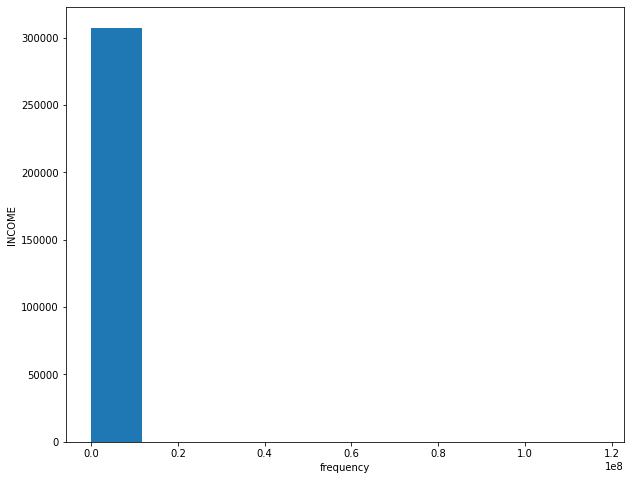

In [0]:
plt.hist(df['AMT_INCOME_TOTAL'])
plt.xlabel("frequency")
plt.ylabel("INCOME")

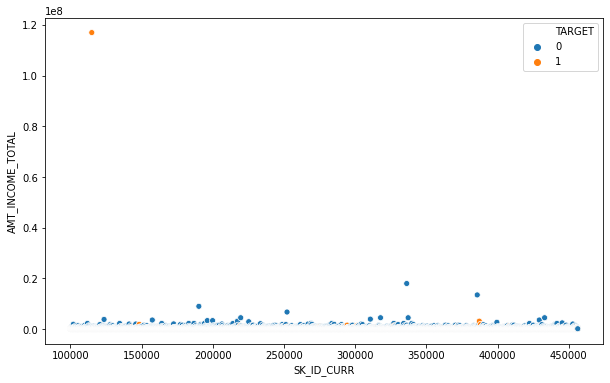

In [0]:
plt.figure(figsize=(10,6))
sns.scatterplot(sk_id_curr, df['AMT_INCOME_TOTAL'], hue=df['TARGET'])

This plot is NOT very informative, but it tells us that the there are definitely some outliers in the data. One of the incomes is close to 1.2 million USD. Lets find out the various percentiles of the data.

In [0]:
amt_income_total = np.array(df['AMT_INCOME_TOTAL'])

In [0]:
amt_income_total = np.sort(amt_income_total)

In [0]:
Q1 = np.percentile(amt_income_total, [25])
income_median = np.median(amt_income_total)
Q3 = np.percentile(amt_income_total, [75])
IQR = Q3 - Q1
print("25th percentile = ", Q1)
print("median = ", income_median)
print("75th percentile = ", Q3)
print("IQR = ", IQR)
print("1.5*IQR =", 1.5*IQR)
income_upper_bound = income_median + 1.5*IQR
income_lower_bound = income_median - 1.5*IQR
print("Income + 1.5*IQR", income_upper_bound)
print("Income - 1.5*IQR", income_lower_bound)

25th percentile =  [112500.]
median =  147150.0
75th percentile =  [202500.]
IQR =  [90000.]
1.5*IQR = [135000.]
Income + 1.5*IQR [282150.]
Income - 1.5*IQR [12150.]


Lets see how the income varies over every 5 percentile change.

Text(0, 0.5, 'Applicant income ( X 100000000)')

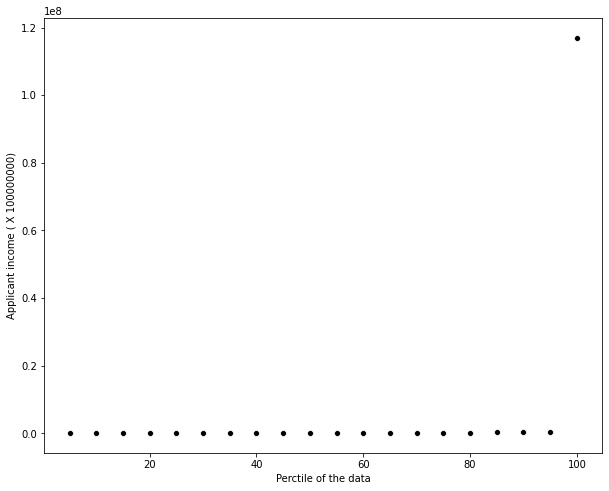

In [0]:
perc_values = np.percentile(amt_income_total, [i for i in range (5, 105, 5)])
perc_list = range(5,105,5)
sns.scatterplot(perc_list, perc_values, marker = 'o', color='black')
plt.xlabel("Perctile of the data")
plt.ylabel("Applicant income ( X 100000000)")

Upto 95 percentile, the data follows a trend. After that, there seem to be outliers.

In [0]:
outlier_large = amt_income_total > (np.median(amt_income_total) + (1.5*IQR))
outlier_small = amt_income_total < (np.median(amt_income_total) - (1.5*IQR)) 
sum(outlier_small), sum(outlier_large)

(0, 26745)

There are 26745 points which are more than than 1.5 * IQR away from the median. Lets see if dropping the outliers helps us visualise the data better 

In [0]:
amt_income_total_no_outlier = amt_income_total[:-26745]

Text(0, 0.5, 'INCOME')

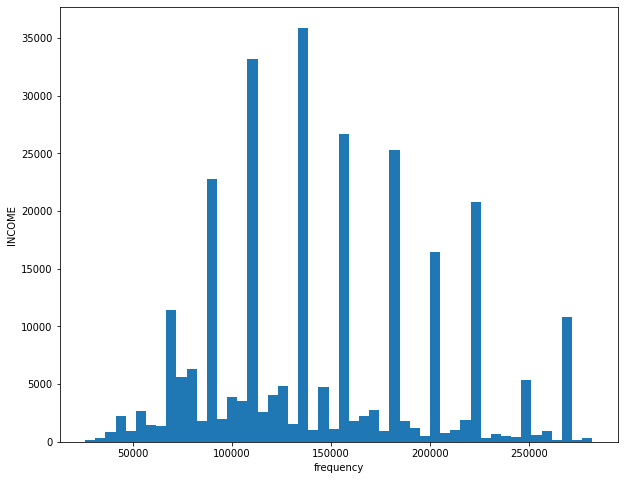

In [0]:
plt.hist(amt_income_total_no_outlier, bins=50)
plt.xlabel("frequency")
plt.ylabel("INCOME")

After dropping the extremely high income values, we see the income spread is very uneven. Though this helps us visualise, we cannot drop all these columns as they may contain important data for modelling.

(0.0, 2000000.0)

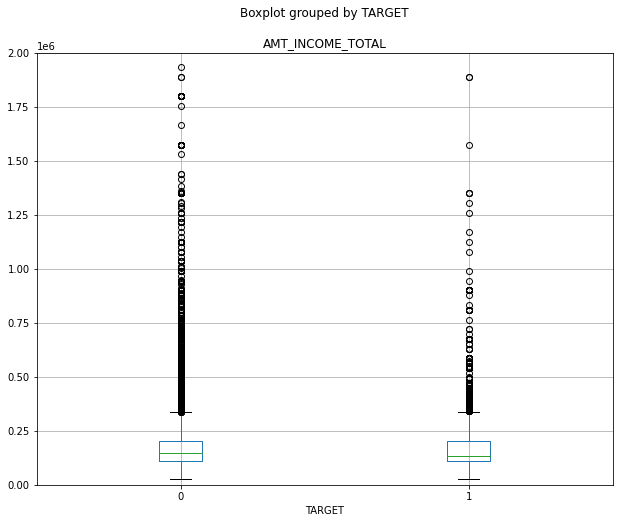

In [0]:
df.boxplot(by='TARGET', column='AMT_INCOME_TOTAL')
plt.ylim(0,2e6)

As expected, high income customers are more densely present in the good loans category.

# AMT_CREDIT

Lets see the distribution of AMT_CREDIT, i.e. the amount of loan taken by the borrower.

(array([1.25018e+05, 1.12767e+05, 4.46440e+04, 1.87860e+04, 4.85000e+03,
        1.03000e+03, 3.73000e+02, 2.30000e+01, 8.00000e+00, 1.20000e+01]),
 array([  45000.,  445500.,  846000., 1246500., 1647000., 2047500.,
        2448000., 2848500., 3249000., 3649500., 4050000.]),
 <a list of 10 Patch objects>)

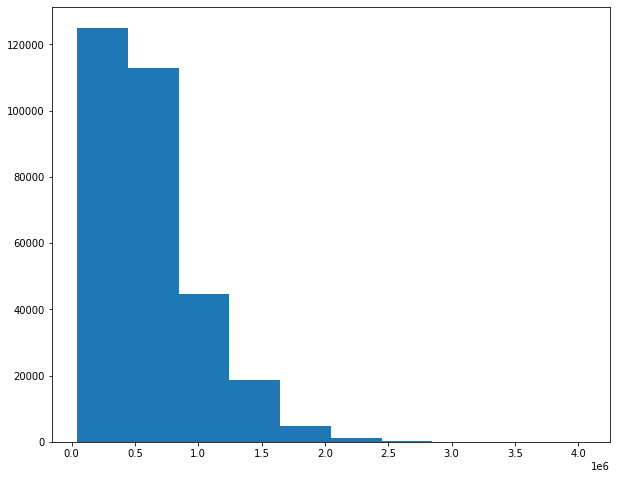

In [0]:
plt.hist(df['AMT_CREDIT'])

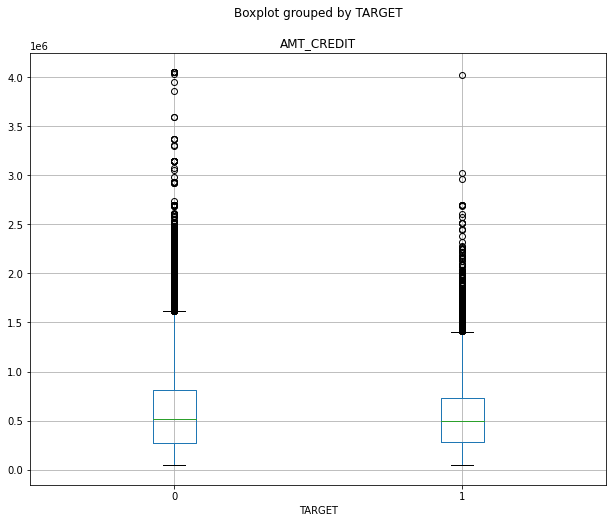

In [0]:
df.boxplot(by='TARGET', column='AMT_CREDIT')

The median incomes of good and bad loans are fairly similar. 
Interestinngly, bigger loans (higher value of AMT_CREDIT) seem to be in good status.

Lets see if income of the applicant and credit amount are somehow related.

Text(0, 0.5, 'CREDIT AMOUNT')

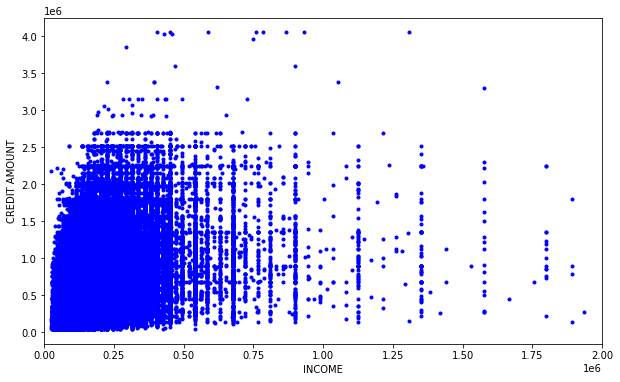

In [0]:
plt.plot(df['AMT_INCOME_TOTAL'], df['AMT_CREDIT'], linestyle = "None", marker = '.', color="blue")
plt.xlim(0,2e6)   # as the density of income data is below 2000000. This will help us visualize better.
plt.xlabel("INCOME")
plt.ylabel("CREDIT AMOUNT")

There seems to be no overall relationship between the income and the requested credit amount.

Lets see if there is anything intersting in good and bad loans, separately.

<Figure size 720x1152 with 0 Axes>

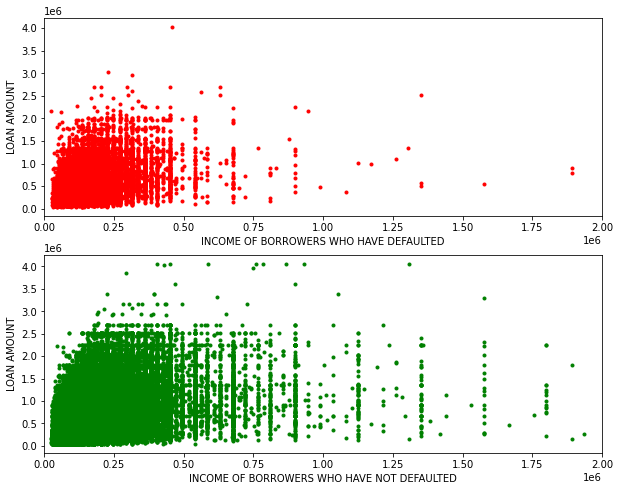

In [0]:
plt.figure(figsize=(10,16))
plt.subplots(2,1, sharex=True)
plt.subplot(2,1,1)
plt.plot(df_bad['AMT_INCOME_TOTAL'], df_bad['AMT_CREDIT'], linestyle="None", marker = '.', color='red')
plt.xlim(0,2e6)
plt.xlabel("INCOME OF BORROWERS WHO HAVE DEFAULTED")
plt.ylabel("LOAN AMOUNT")
plt.subplot(2,1,2)
plt.plot(df_good['AMT_INCOME_TOTAL'], df_good['AMT_CREDIT'], linestyle="None", marker = '.', color='green')
plt.xlim(0,2e6)
plt.xlabel("INCOME OF BORROWERS WHO HAVE NOT DEFAULTED")
plt.ylabel("LOAN AMOUNT")
plt.show()

The majority of the loans are in the low-income, low-credit category. Borrowers with high income are more widely present in the good-loans category. This is expected.
Also, relatively higher loan amounts are present in the good-loans category.

# AMT_ANNUITY

Annuity is the amount the the borrower pays annually to HOME CREDIT for the repayment of the loan.

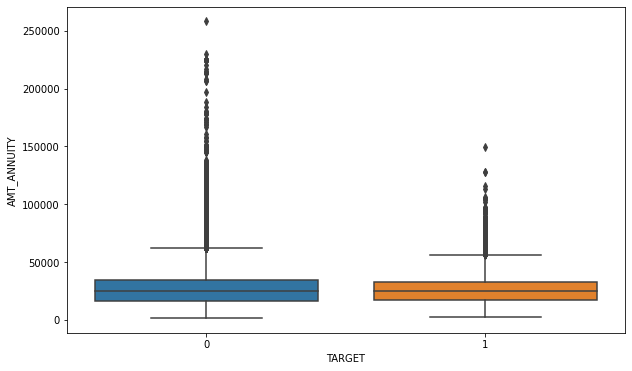

In [0]:
sns.boxplot(x=df['TARGET'], y= df['AMT_ANNUITY'])

The median annuity amount is fairly similar for both bad and  good loans. 
Interestingly, borrowers with higher annuities are more frequent in the good-loans category. 
Thus, havong to pay a higher installment does not necessarily imply more chances of default.

Lets see if there any missing values in this column.

In [0]:
df['AMT_ANNUITY'].isnull().sum()

12

In [0]:
df.loc[df['AMT_ANNUITY'].isnull(),:]

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
47531,0,Cash loans,M,N,N,0,180000.0,450000.0,NaN,450000.0,Unaccompanied,Commercial associate,Incomplete higher,Single / not married,House / apartment,0.026392,-10668,-2523,-4946.0,-3238,NaN,1,1,1,1,1,0,High skill tech staff,1.0,2,2,WEDNESDAY,13,0,0,0,0,0,0,Business Entity Type 3,...,NaN,0.0117,NaN,0.0000,NaN,block of flats,0.0090,"Stone, brick",No,1.0,0.0,1.0,0.0,-2.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
50035,0,Cash loans,F,N,N,0,94500.0,450000.0,NaN,450000.0,Unaccompanied,Working,Lower secondary,Civil marriage,House / apartment,0.035792,-9027,-1270,-3640.0,-741,NaN,1,1,1,1,0,0,Laborers,2.0,2,2,MONDAY,20,0,0,0,0,0,0,Business Entity Type 1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-706.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,1.0
51594,0,Cash loans,F,N,N,0,202500.0,539100.0,NaN,450000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.046220,-17376,-3950,-11524.0,-831,NaN,1,1,0,1,0,0,Cooking staff,2.0,1,1,WEDNESDAY,15,0,0,0,1,1,1,Self-employed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,-199.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,1.0
55025,0,Cash loans,F,N,N,0,162000.0,296280.0,NaN,225000.0,Unaccompanied,State servant,Higher education,Married,House / apartment,0.035792,-11329,-2040,-3195.0,-3069,NaN,1,1,0,1,0,0,Core staff,2.0,2,2,FRIDAY,13,0,0,0,1,1,1,Government,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-2841.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,4.0
59934,0,Cash loans,M,Y,N,0,202500.0,360000.0,NaN,360000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.046220,-19762,-2498,-11285.0,-3305,4.0,1,1,1,1,1,0,Laborers,1.0,1,1,FRIDAY,15,0,1,1,0,1,1,Other,...,NaN,0.0558,NaN,0.1163,NaN,block of flats,0.0679,"Stone, brick",No,0.0,0.0,0.0,0.0,-743.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,6.0
75873,0,Cash loans,M,Y,N,0,144000.0,219249.0,NaN,166500.0,Unaccompanied,Working,Higher education,Single / not married,Rented apartment,0.022800,-20831,-2450,-771.0,-4203,8.0,1,1,0,1,0,0,Drivers,1.0,2,2,FRIDAY,15,0,0,0,0,0,0,Business Entity Type 3,...,0.0761,0.0880,0.0039,0.0032,not specified,block of flats,0.0687,Panel,No,0.0,0.0,0.0,0.0,-1986.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,11.0
89343,0,Cash loans,F,Y,N,0,90000.0,157500.0,NaN,157500.0,Unaccompanied,State servant,Secondary / secondary special,Married,House / apartment,0.01522

# AMT_GOODS_PRICE

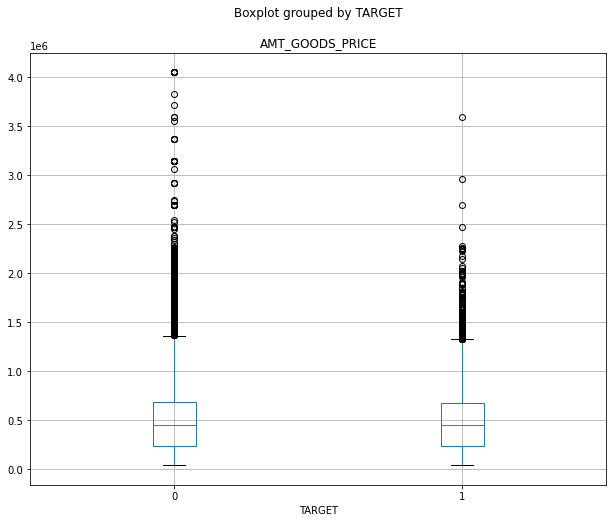

In [0]:
df.boxplot(by='TARGET', column='AMT_GOODS_PRICE')

The median goods price for good and bad loans are fairly similar. 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fccda040da0>,
      dtype=object)

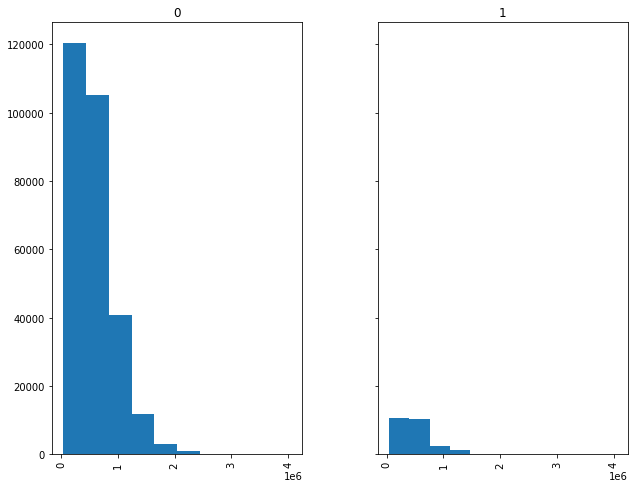

In [0]:
df.hist(column='AMT_GOODS_PRICE', by='TARGET', sharey=True, sharex=True)

Interestingly, loans for higher priced goods are still being repaid properly.

# REGION_POPULARION_RELATIVE

It represents the relative population of the region where borrower lives

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f282b3d47f0>,
      dtype=object)

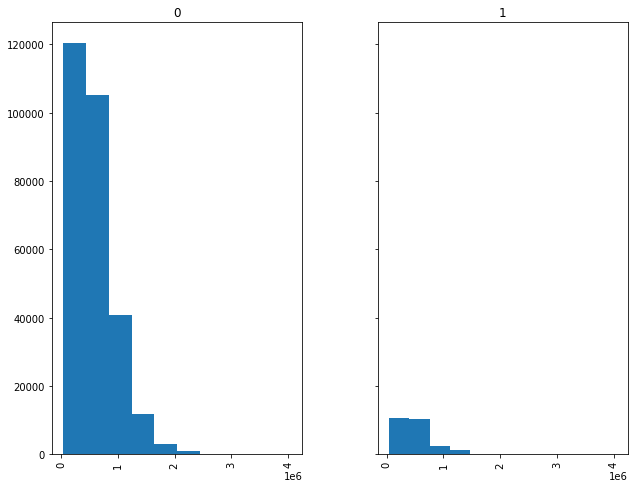

In [0]:
df.hist(column='AMT_GOODS_PRICE', by='TARGET', sharey=True, sharex=True)

It looks like borrowers of sparsely populated regions are defualting more.

# DAYS_BIRTH

This column is the number of days passed since the borrower was born, but the values are all presented as negative integers. Lets first get the age from this data and make the column positive.

In [0]:
borrower_age = df['DAYS_BIRTH'] / -365.0

Text(0, 0.5, 'Borrower age in years')

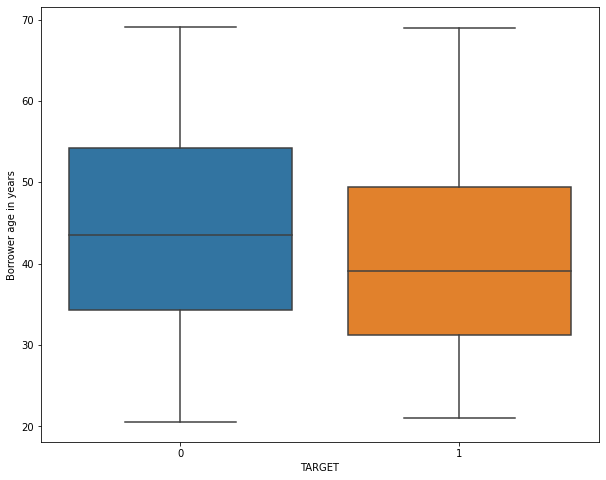

In [0]:
sns.boxplot(x=df['TARGET'], y= borrower_age)
plt.ylabel("Borrower age in years")

It seems that younger borrowers tend to default more.

# DAYS_EMPLOYED

Since how many days the borrower has been employed, before the application date. This too contains negative values.

In [0]:
df[df['DAYS_EMPLOYED'] < 0]['DAYS_EMPLOYED'].value_counts()

-200      156
-224      152
-199      151
-230      151
-212      150
         ... 
-10533      1
-10661      1
-12872      1
-14887      1
-12105      1
Name: DAYS_EMPLOYED, Length: 12572, dtype: int64

Highest magnitude is 12105. Lets check to see if there are any positive values.



In [0]:
df[df['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED'].value_counts()

365243    55374
Name: DAYS_EMPLOYED, dtype: int64

In [0]:
print(365243/365.0)

1000.6657534246575


365243 days means 1000 years!!!
This is impossible, hence these values are garbage values. Lets plot the data. We will replace the null values with the mean of the column and see analyse the difference in modelling.

In [0]:
df.loc[df['DAYS_EMPLOYED'] > 0,'DAYS_EMPLOYED'] = np.nan

In [0]:
years_employed = df['DAYS_EMPLOYED'] / -365.0

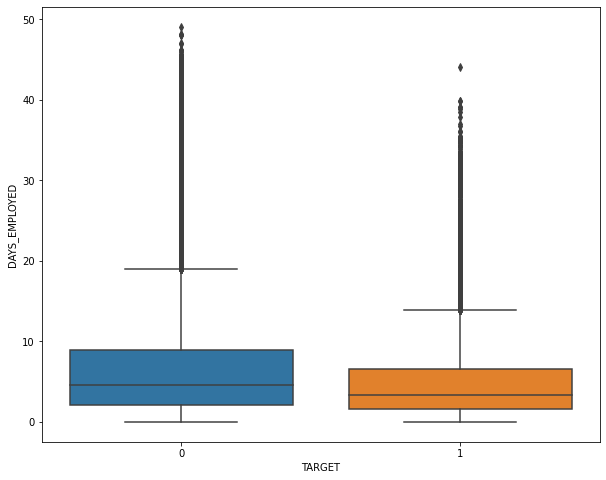

In [0]:
sns.boxplot(x=df['TARGET'], y = years_employed)

 1.   Majority of the borrowers have less than 10 years of experience.
 2.   People with relatively less working experience tend to default more. This may be due the fact that more experienced borrowers may be having higher repayment capacity.

# DAYS_REGISTRATION

Number of days before that application date, when borrower changed his/her registration.

In [0]:
df['DAYS_REGISTRATION'] = -df['DAYS_REGISTRATION']

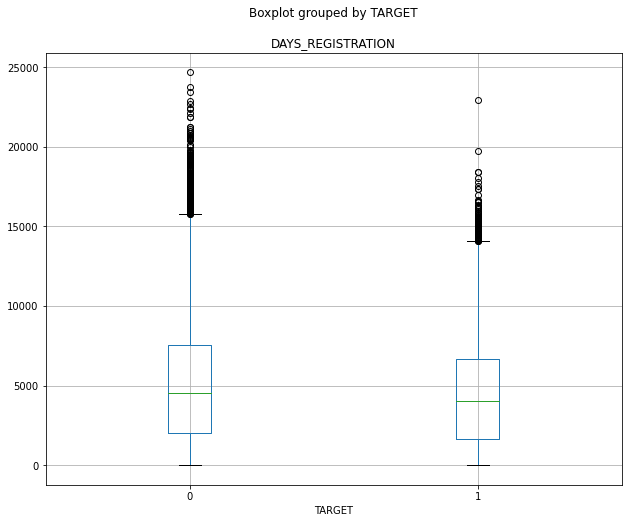

In [0]:
df.boxplot(column='DAYS_REGISTRATION', by= 'TARGET')

Defaulters seem to have changed their registration more recently. 

# DAYS_ID_PUBLISH

How many days before the application did client change the identity document with which he applied for the loan.

Lets convert this to positive.

In [0]:
df['DAYS_ID_PUBLISH'] = -df['DAYS_ID_PUBLISH']

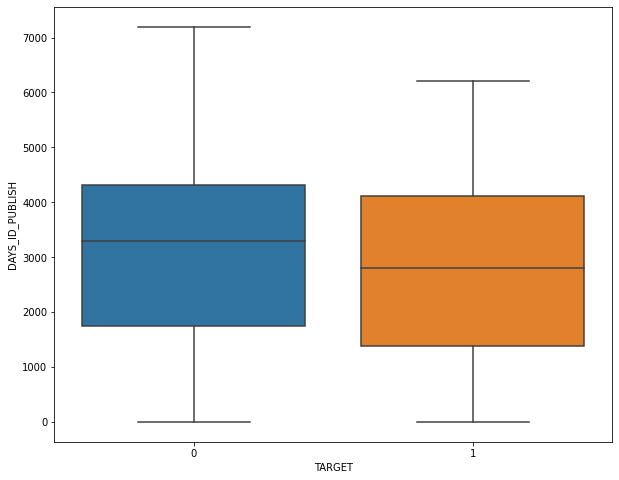

In [0]:
sns.boxplot(x='TARGET', y='DAYS_ID_PUBLISH', data=df)

Although people who have changed their ID recently tend to default slighly more, the difference is not pronounced

# OWN_CAR_AGE

In [0]:
df['OWN_CAR_AGE'].isnull().sum()

202929

about two thirds of the values are null values. This is because these many clients do not own a car.

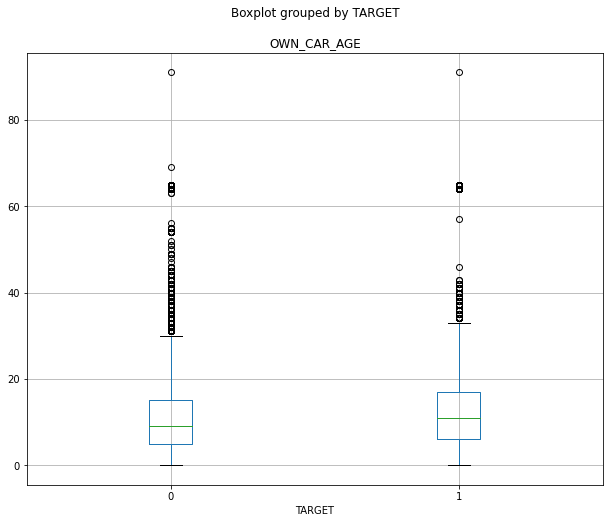

In [0]:
df.boxplot(column='OWN_CAR_AGE', by='TARGET')

Both kinds of borrowers (defaulters and non-defaulters) have a similar median car age. There doesn't seem to be much of difference.

# Residential building attributes

The next set of columns represent the various attributes of the building where the borrower lives. They contain normalized values of -

*   average (_AVG suffix)
*   mode (_MODE suffix)
*   median (_MEDI suffix)

...of the apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floors present.

Lets plot all of them to see if we find anything interesting.

In [0]:
residential_building_attributes = ['APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 
                                   'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 
                                   'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG',
                                   'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE',
                                   'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 
                                   'FLOORSMIN_MODE', 'LANDAREA_MODE',  'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
                                   'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 
                                   'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 
                                   'ENTRANCES_MEDI', 'FLOORSMAX_MEDI','FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 
                                   'LIVINGAREA_MEDI','NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'TOTALAREA_MODE']

Average value of APARTMENTS_AVG for defaulters (bad loans):  0.10576637571157398
Average value of APARTMENTS_AVG for non-defaulters (good loans):  0.1183137179760294


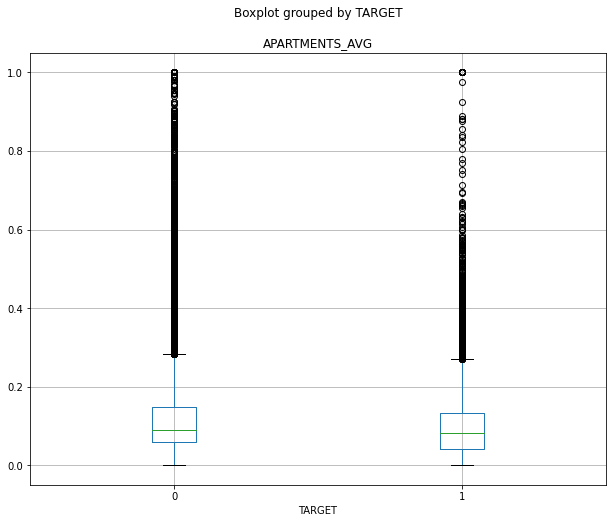

Average value of BASEMENTAREA_AVG for defaulters (bad loans):  0.08154808239444662
Average value of BASEMENTAREA_AVG for non-defaulters (good loans):  0.08895222299862807


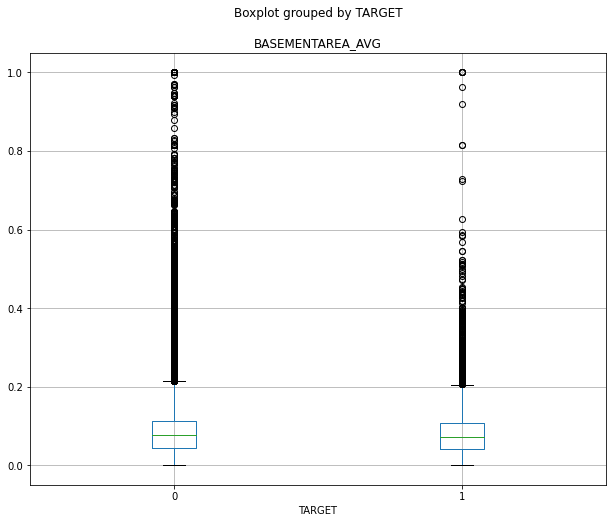

Average value of YEARS_BEGINEXPLUATATION_AVG for defaulters (bad loans):  0.9756341381501527
Average value of YEARS_BEGINEXPLUATATION_AVG for non-defaulters (good loans):  0.9778928491947323


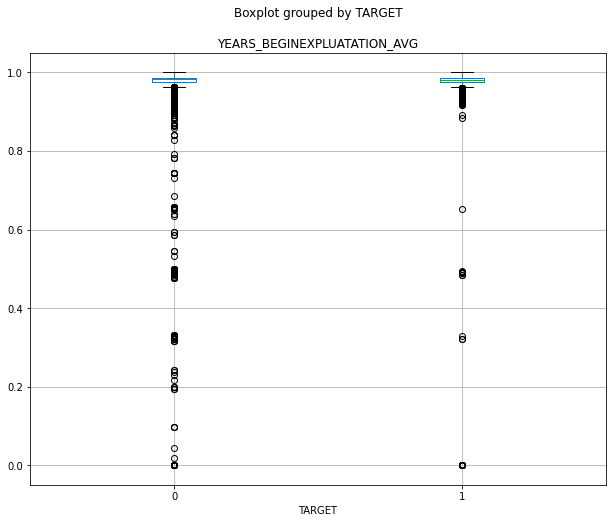

Average value of YEARS_BUILD_AVG for defaulters (bad loans):  0.7432308736217134
Average value of YEARS_BUILD_AVG for non-defaulters (good loans):  0.7531527082095423


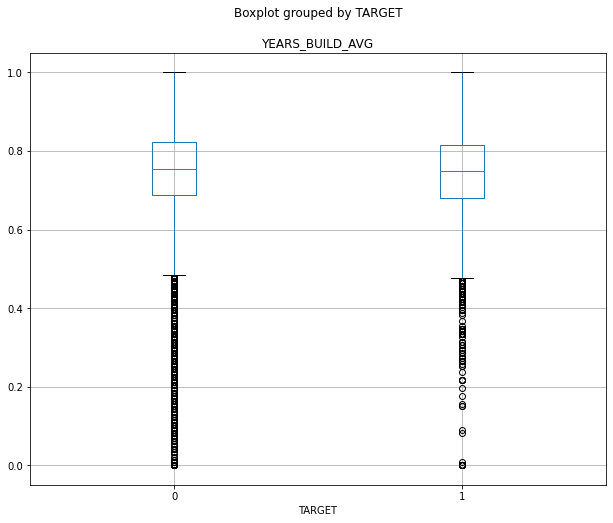

Average value of COMMONAREA_AVG for defaulters (bad loans):  0.03944395501405808
Average value of COMMONAREA_AVG for non-defaulters (good loans):  0.0450049928110952


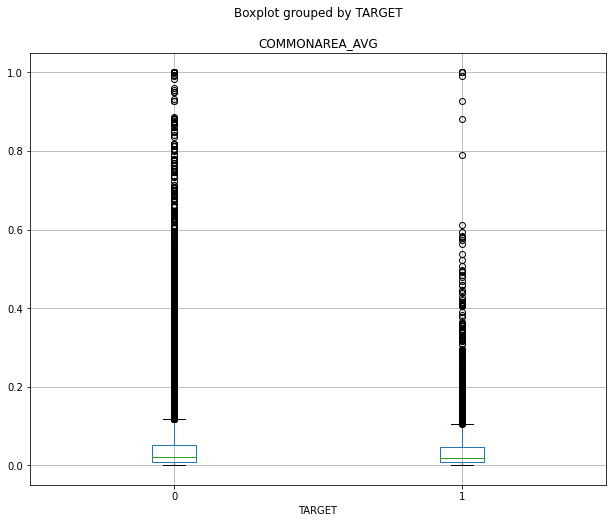

Average value of ELEVATORS_AVG for defaulters (bad loans):  0.06203624621594435
Average value of ELEVATORS_AVG for non-defaulters (good loans):  0.0801944566599262


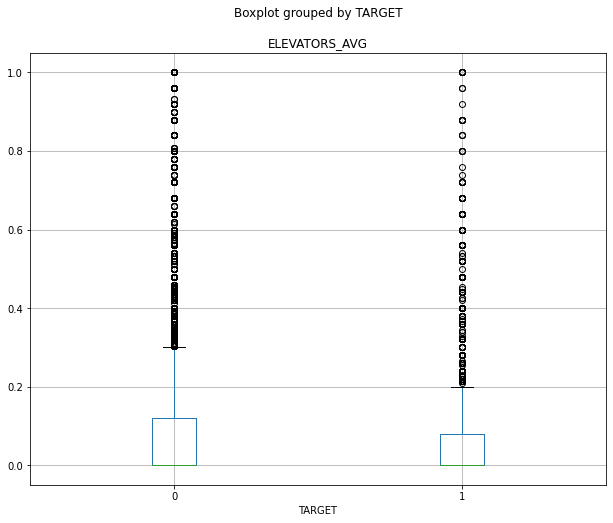

Average value of ENTRANCES_AVG for defaulters (bad loans):  0.14270699076689322
Average value of ENTRANCES_AVG for non-defaulters (good loans):  0.15024896212406805


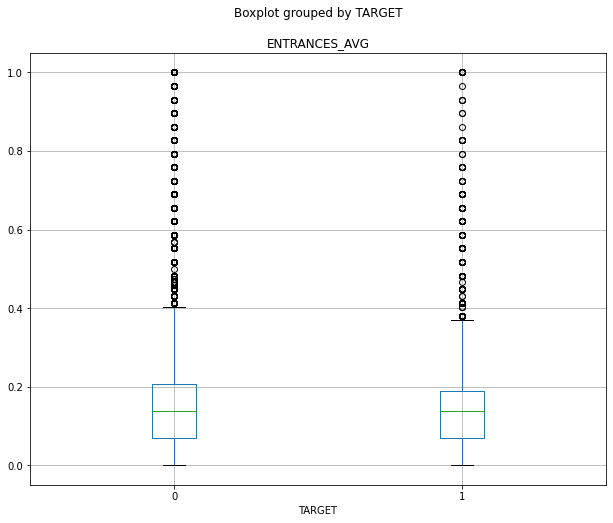

Average value of FLOORSMAX_AVG for defaulters (bad loans):  0.20302122479323587
Average value of FLOORSMAX_AVG for non-defaulters (good loans):  0.22802342378086699


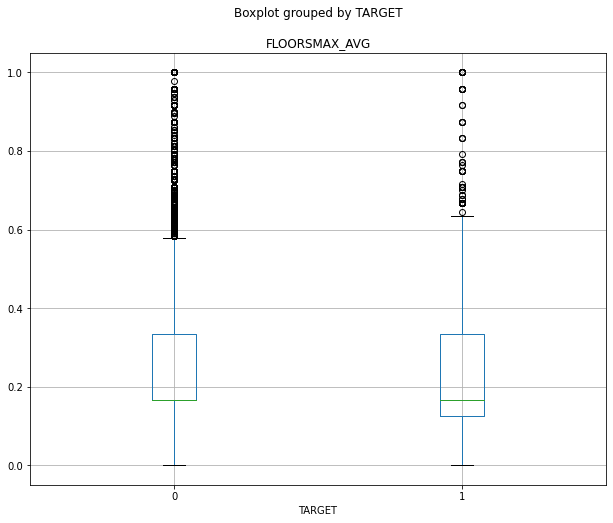

Average value of FLOORSMIN_AVG for defaulters (bad loans):  0.21196007041220566
Average value of FLOORSMIN_AVG for non-defaulters (good loans):  0.23336968995782023


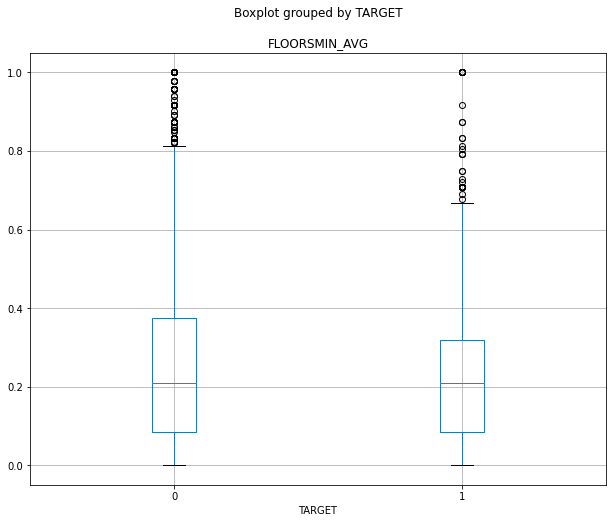

Average value of LANDAREA_AVG for defaulters (bad loans):  0.0631076023391812
Average value of LANDAREA_AVG for non-defaulters (good loans):  0.06657526936316793


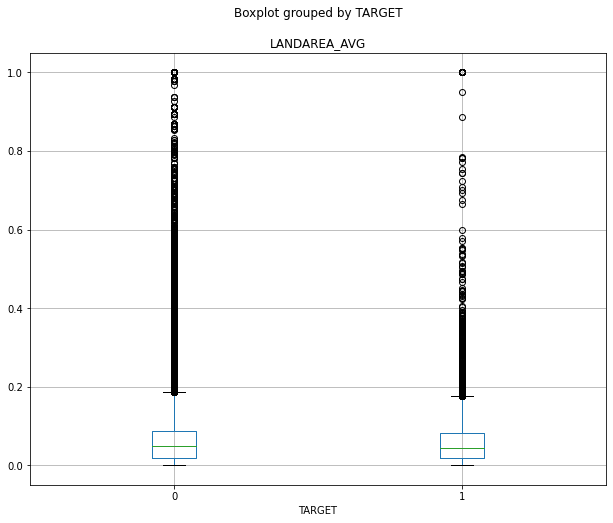

Average value of LIVINGAPARTMENTS_AVG for defaulters (bad loans):  0.09225519916455452
Average value of LIVINGAPARTMENTS_AVG for non-defaulters (good loans):  0.10140502930173274


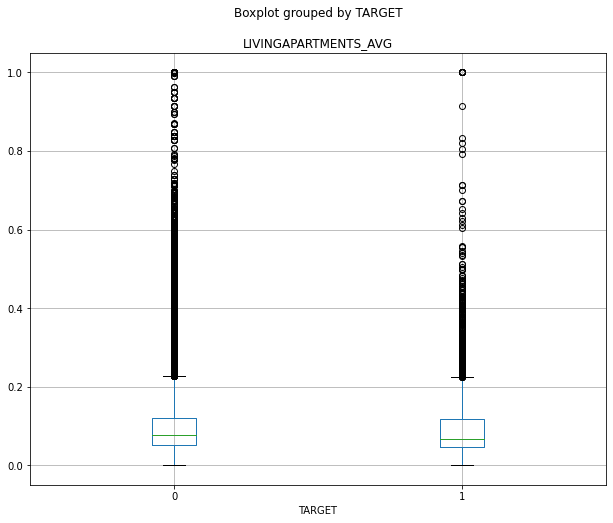

Average value of LIVINGAREA_AVG for defaulters (bad loans):  0.09409627590069043
Average value of LIVINGAREA_AVG for non-defaulters (good loans):  0.10839957106853639


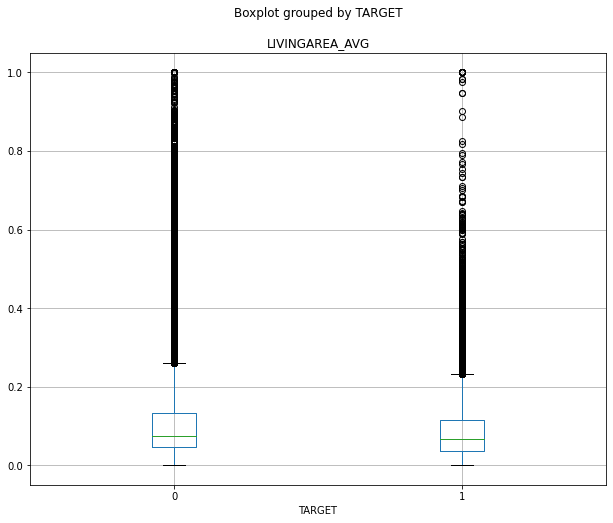

Average value of NONLIVINGAPARTMENTS_AVG for defaulters (bad loans):  0.008252369959987913
Average value of NONLIVINGAPARTMENTS_AVG for non-defaulters (good loans):  0.008849985714123897


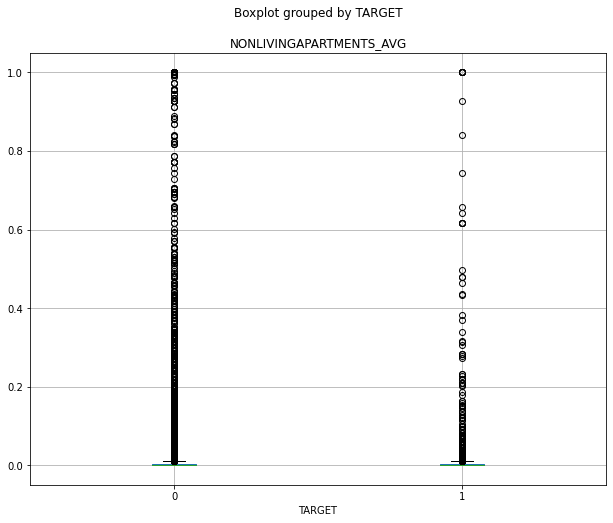

Average value of NONLIVINGAREA_AVG for defaulters (bad loans):  0.02488727751448136
Average value of NONLIVINGAREA_AVG for non-defaulters (good loans):  0.028614526158306473


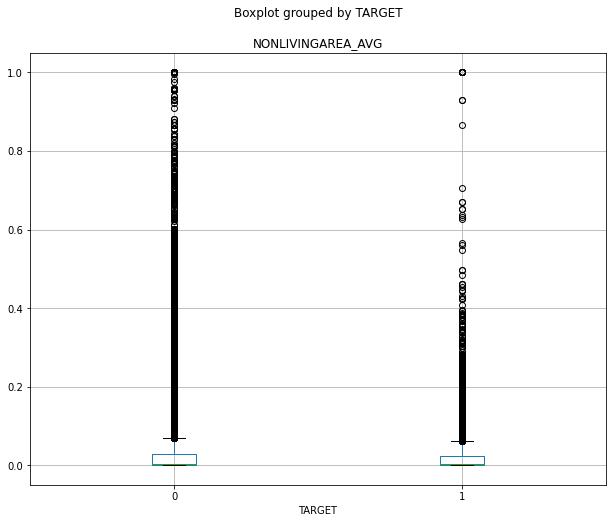

Average value of APARTMENTS_MODE for defaulters (bad loans):  0.10346333965844405
Average value of APARTMENTS_MODE for non-defaulters (good loans):  0.11503642324887972


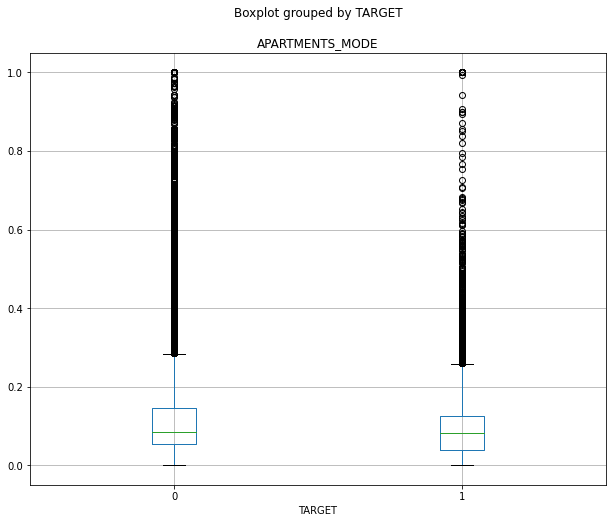

Average value of BASEMENTAREA_MODE for defaulters (bad loans):  0.08135865483100005
Average value of BASEMENTAREA_MODE for non-defaulters (good loans):  0.08800072402151875


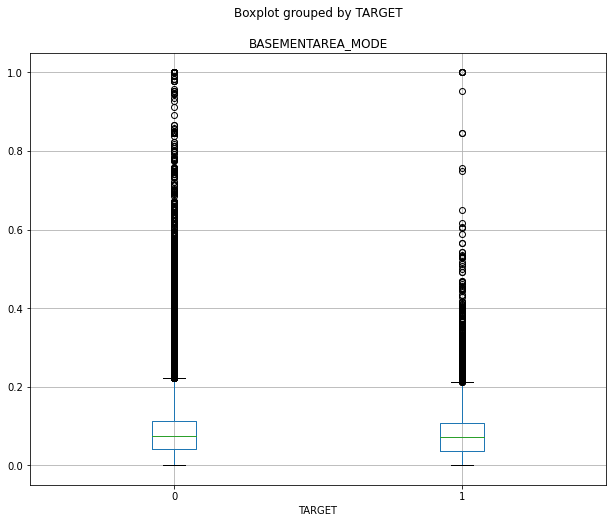

Average value of YEARS_BEGINEXPLUATATION_MODE for defaulters (bad loans):  0.9749375692112201
Average value of YEARS_BEGINEXPLUATATION_MODE for non-defaulters (good loans):  0.9772254008887381


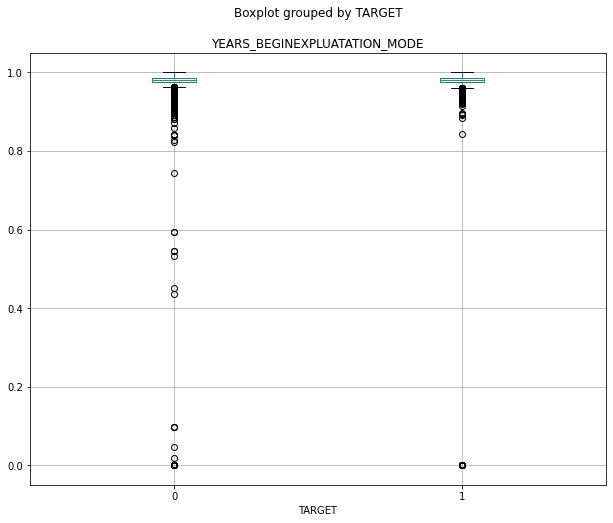

Average value of YEARS_BUILD_MODE for defaulters (bad loans):  0.7506881396663814
Average value of YEARS_BUILD_MODE for non-defaulters (good loans):  0.7602971161763019


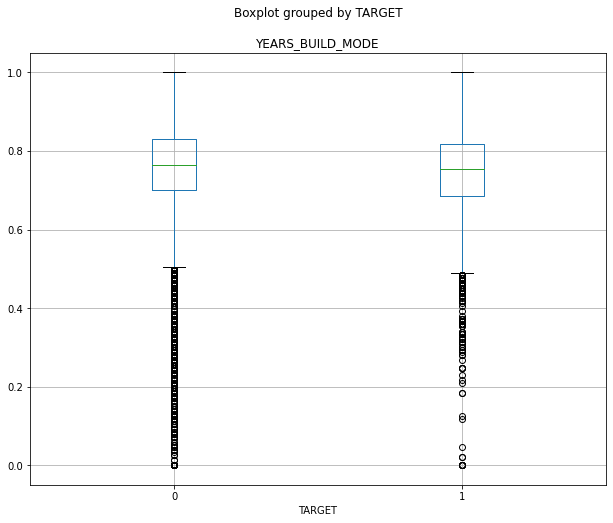

Average value of COMMONAREA_MODE for defaulters (bad loans):  0.0380883786316777
Average value of COMMONAREA_MODE for non-defaulters (good loans):  0.042884562404342144


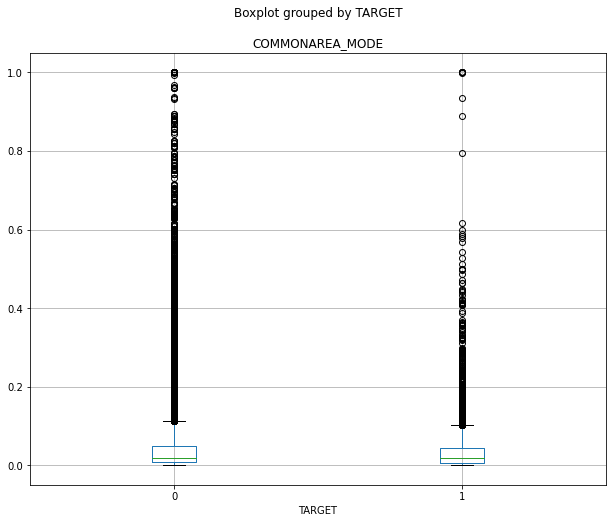

Average value of ELEVATORS_MODE for defaulters (bad loans):  0.058880343087789555
Average value of ELEVATORS_MODE for non-defaulters (good loans):  0.07564663600327372


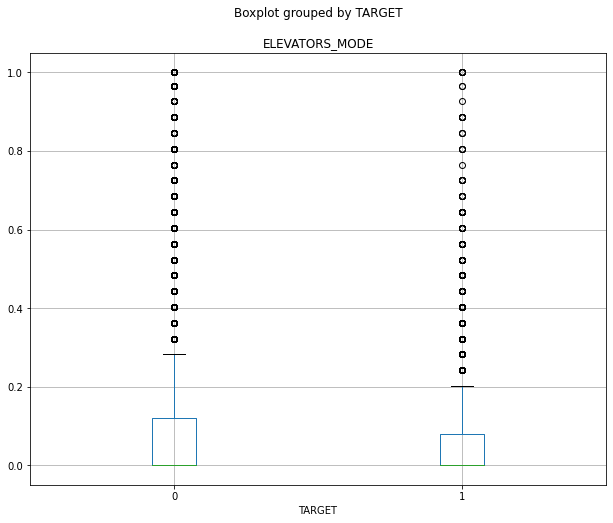

Average value of ENTRANCES_MODE for defaulters (bad loans):  0.1387692387412663
Average value of ENTRANCES_MODE for non-defaulters (good loans):  0.14567255347755162


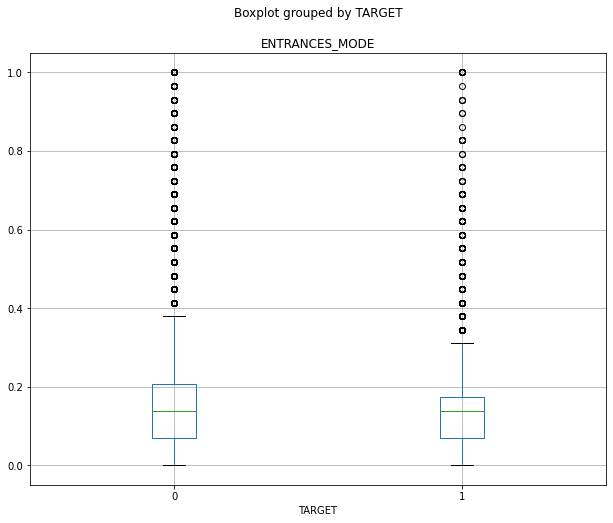

Average value of FLOORSMAX_MODE for defaulters (bad loans):  0.19961227581079907
Average value of FLOORSMAX_MODE for non-defaulters (good loans):  0.22401479371060007


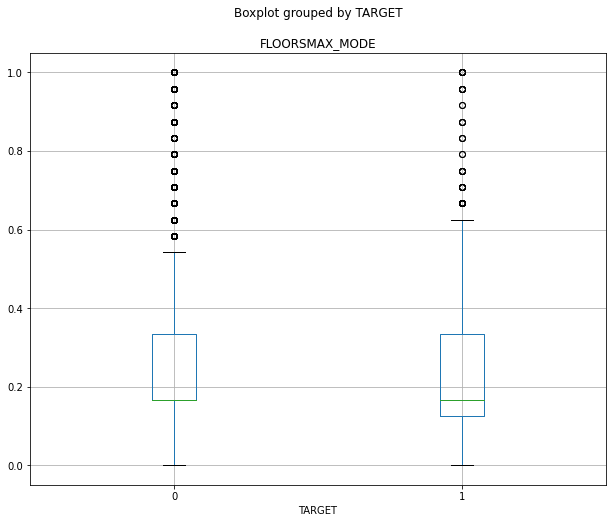

Average value of FLOORSMIN_MODE for defaulters (bad loans):  0.20869457239254927
Average value of FLOORSMIN_MODE for non-defaulters (good loans):  0.22949250640938923


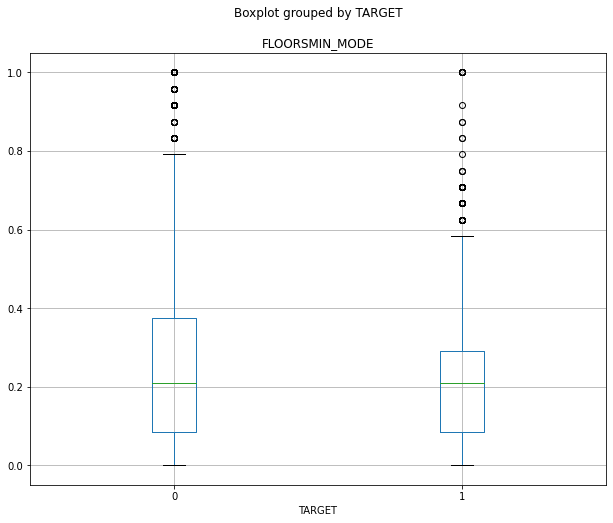

Average value of LANDAREA_MODE for defaulters (bad loans):  0.061921671826625335
Average value of LANDAREA_MODE for non-defaulters (good loans):  0.06518554216867603


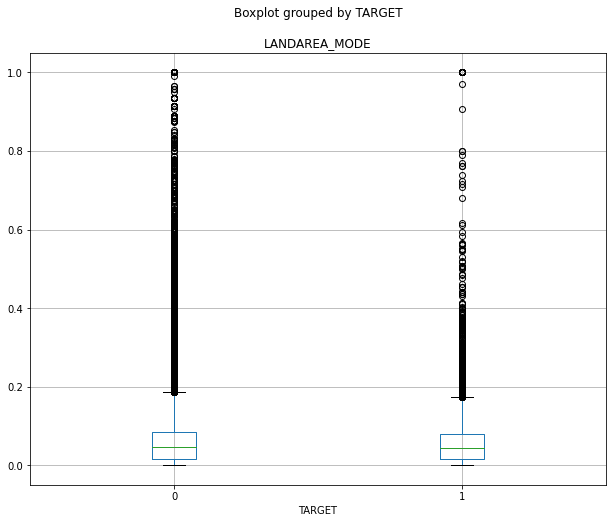

Average value of LIVINGAPARTMENTS_MODE for defaulters (bad loans):  0.09722634641205447
Average value of LIVINGAPARTMENTS_MODE for non-defaulters (good loans):  0.10626763456168638


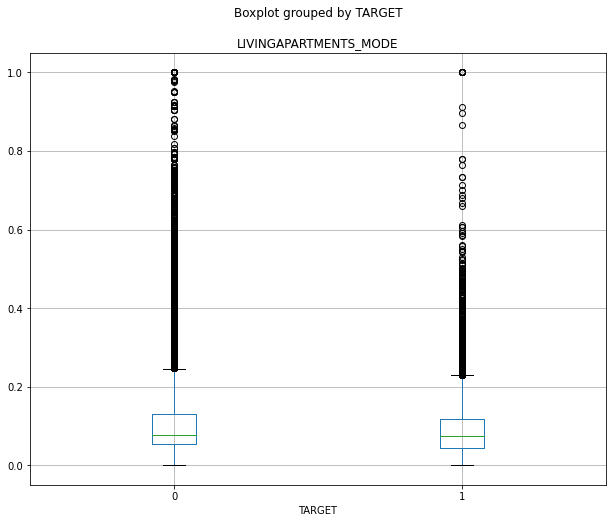

Average value of LIVINGAREA_MODE for defaulters (bad loans):  0.09346129363449716
Average value of LIVINGAREA_MODE for non-defaulters (good loans):  0.10691625938067975


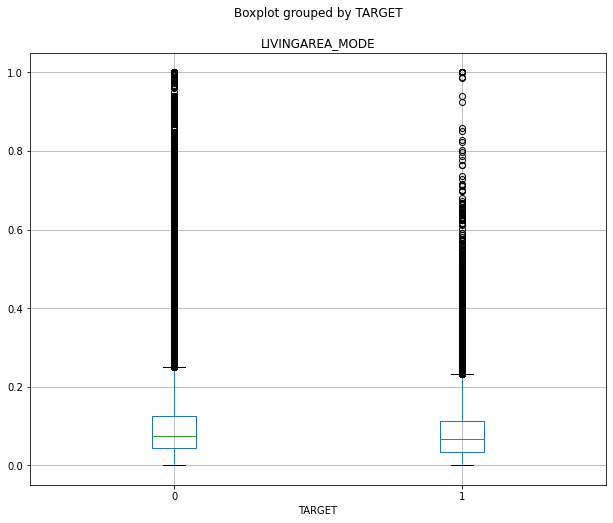

Average value of NONLIVINGAPARTMENTS_MODE for defaulters (bad loans):  0.0078120652508466195
Average value of NONLIVINGAPARTMENTS_MODE for non-defaulters (good loans):  0.008096017097338114


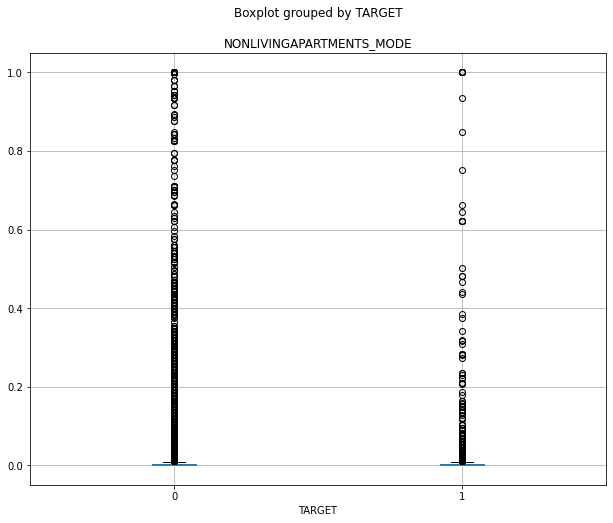

Average value of NONLIVINGAREA_MODE for defaulters (bad loans):  0.023739431279620814
Average value of NONLIVINGAREA_MODE for non-defaulters (good loans):  0.02726520953138003


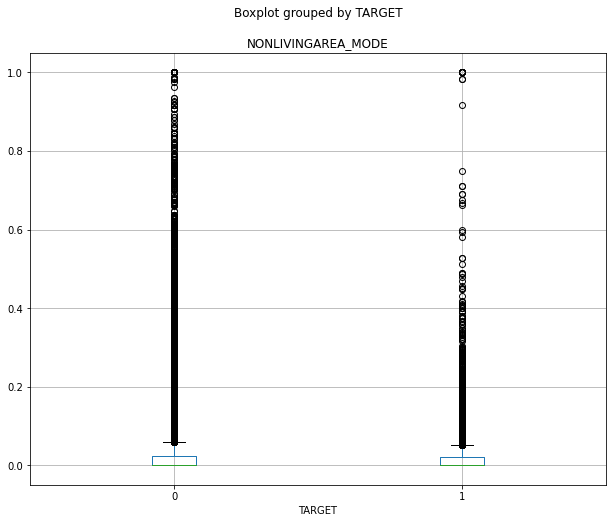

Average value of APARTMENTS_MEDI for defaulters (bad loans):  0.10621082542694545
Average value of APARTMENTS_MEDI for non-defaulters (good loans):  0.11872051948051571


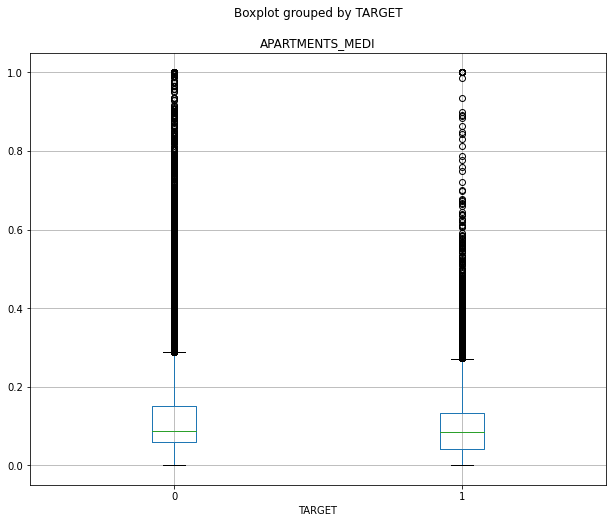

Average value of BASEMENTAREA_MEDI for defaulters (bad loans):  0.08128317969728029
Average value of BASEMENTAREA_MEDI for non-defaulters (good loans):  0.08844840168040391


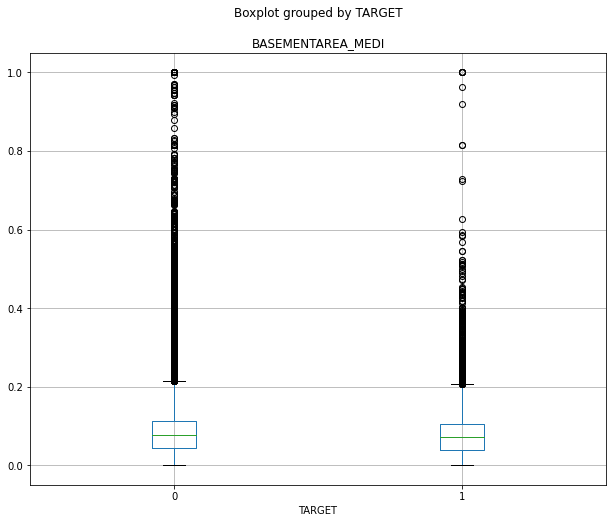

Average value of YEARS_BEGINEXPLUATATION_MEDI for defaulters (bad loans):  0.9755696650631062
Average value of YEARS_BEGINEXPLUATATION_MEDI for non-defaulters (good loans):  0.9779164130604635


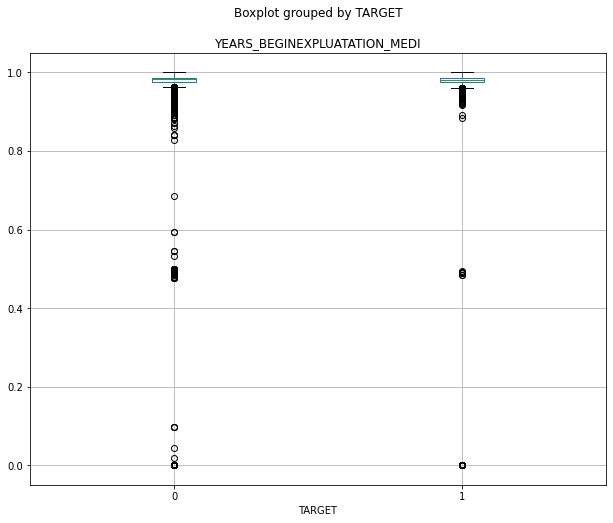

Average value of YEARS_BUILD_MEDI for defaulters (bad loans):  0.7465318066157866
Average value of YEARS_BUILD_MEDI for non-defaulters (good loans):  0.7564256240295005


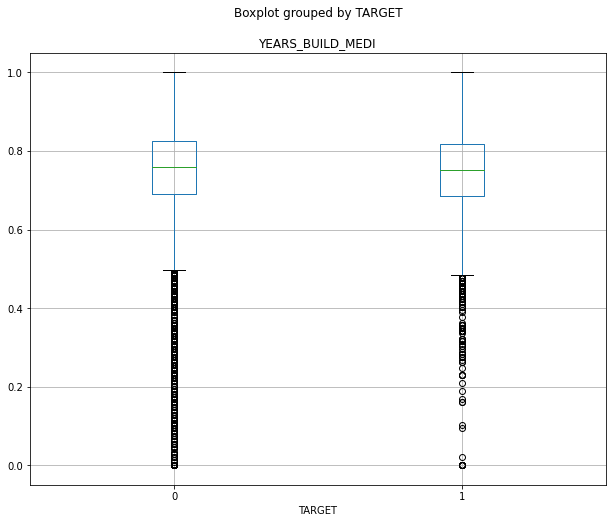

Average value of COMMONAREA_MEDI for defaulters (bad loans):  0.03940446735395204
Average value of COMMONAREA_MEDI for non-defaulters (good loans):  0.044980409071935824


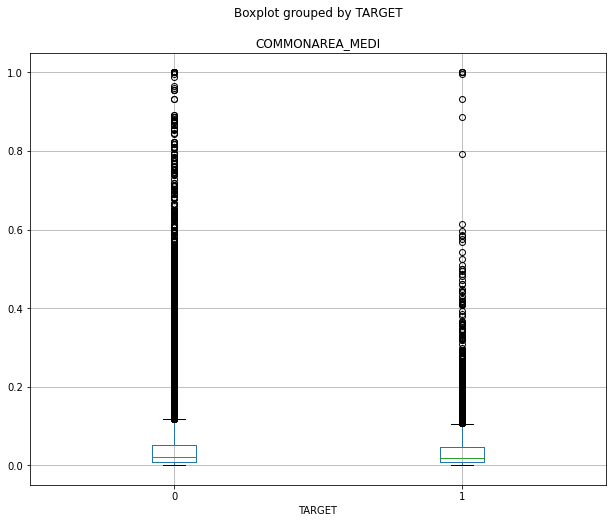

Average value of ELEVATORS_MEDI for defaulters (bad loans):  0.06135216952573247
Average value of ELEVATORS_MEDI for non-defaulters (good loans):  0.07931747812428787


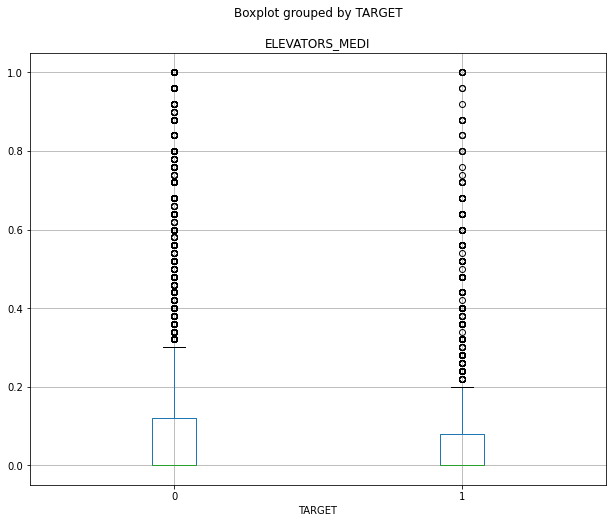

Average value of ENTRANCES_MEDI for defaulters (bad loans):  0.14222684190689633
Average value of ENTRANCES_MEDI for non-defaulters (good loans):  0.14973470144791587


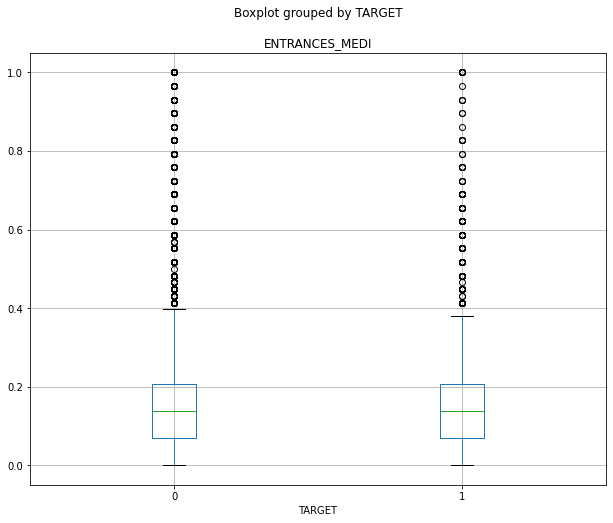

Average value of FLOORSMAX_MEDI for defaulters (bad loans):  0.20269217544837956
Average value of FLOORSMAX_MEDI for non-defaulters (good loans):  0.22763389410717524


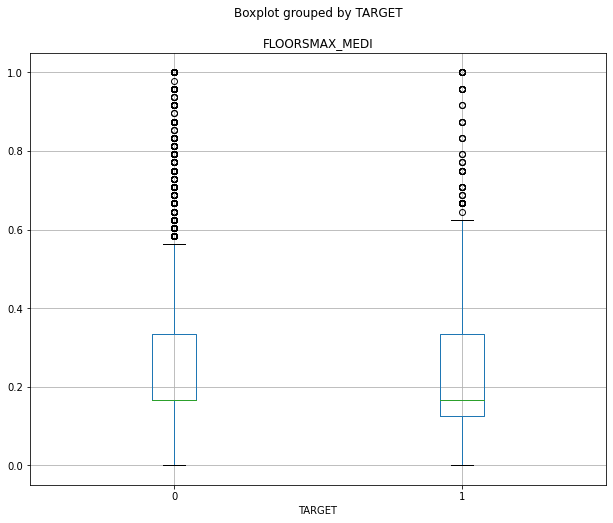

Average value of FLOORSMIN_MEDI for defaulters (bad loans):  0.21175361596010095
Average value of FLOORSMIN_MEDI for non-defaulters (good loans):  0.23309652804932965


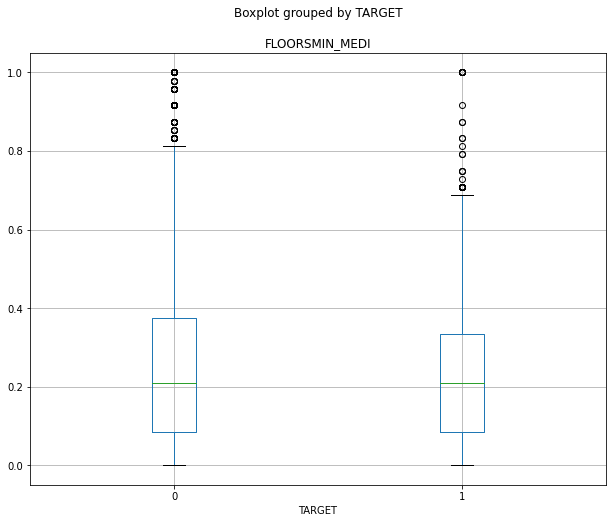

Average value of LANDAREA_MEDI for defaulters (bad loans):  0.06379282192409123
Average value of LANDAREA_MEDI for non-defaulters (good loans):  0.06742211790017315


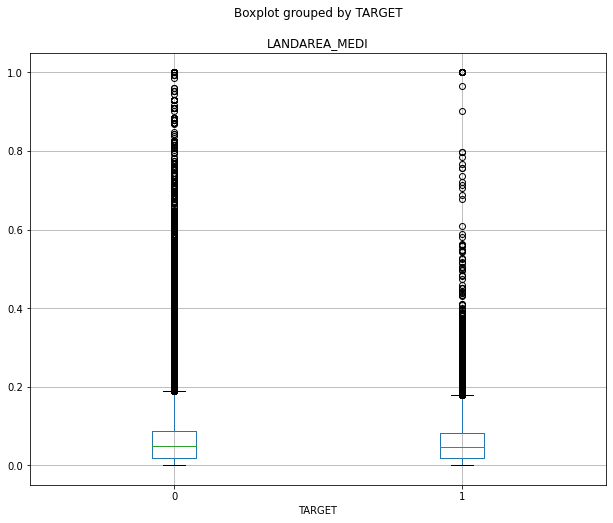

Average value of LIVINGAPARTMENTS_MEDI for defaulters (bad loans):  0.09347789049679564
Average value of LIVINGAPARTMENTS_MEDI for non-defaulters (good loans):  0.1025815470869585


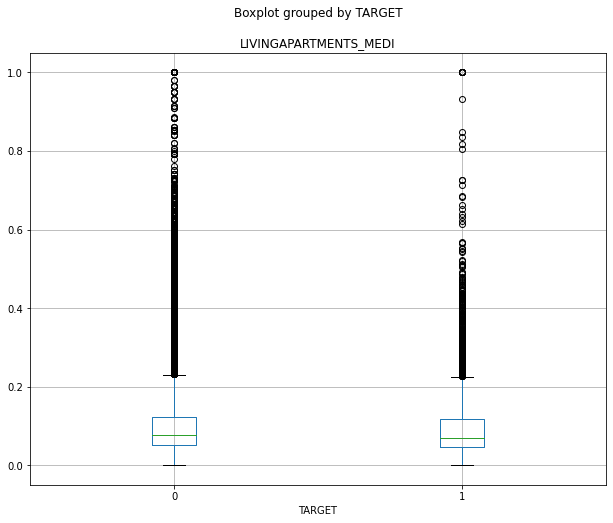

Average value of LIVINGAREA_MEDI for defaulters (bad loans):  0.09520550681351511
Average value of LIVINGAREA_MEDI for non-defaulters (good loans):  0.10961469529017559


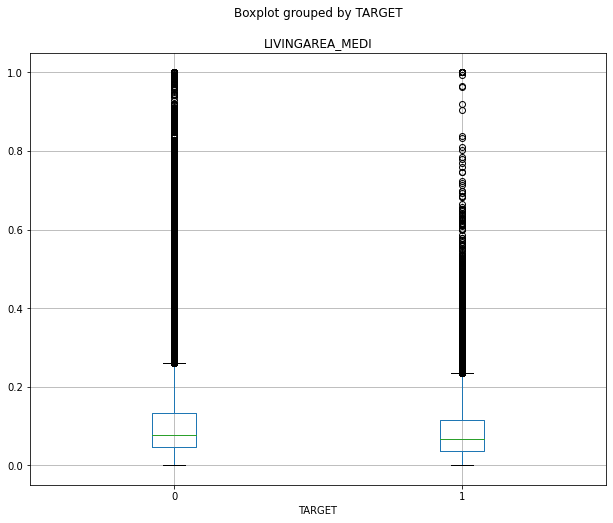

Average value of NONLIVINGAPARTMENTS_MEDI for defaulters (bad loans):  0.008171298861188376
Average value of NONLIVINGAPARTMENTS_MEDI for non-defaulters (good loans):  0.008686638704442518


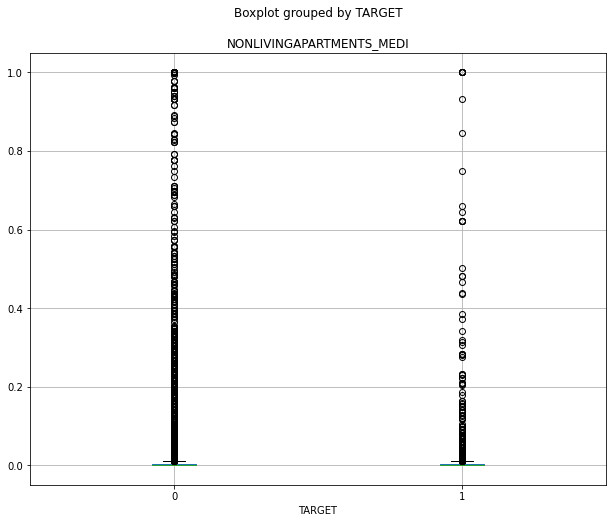

Average value of NONLIVINGAREA_MEDI for defaulters (bad loans):  0.024795587151132125
Average value of NONLIVINGAREA_MEDI for non-defaulters (good loans):  0.02849045927034243


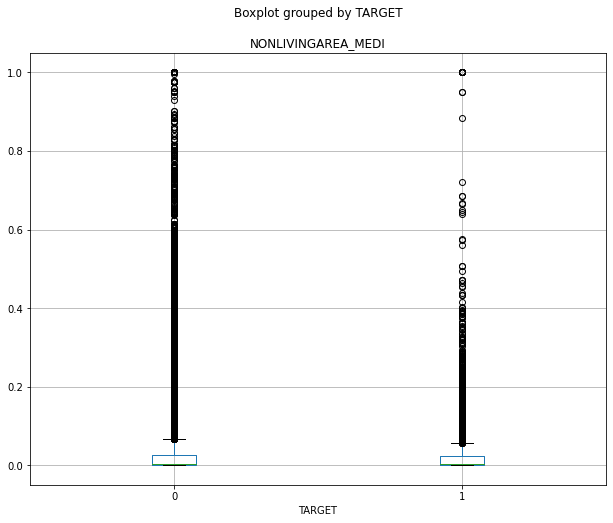

Average value of TOTALAREA_MODE for defaulters (bad loans):  0.08976892706178605
Average value of TOTALAREA_MODE for non-defaulters (good loans):  0.1035068862740845


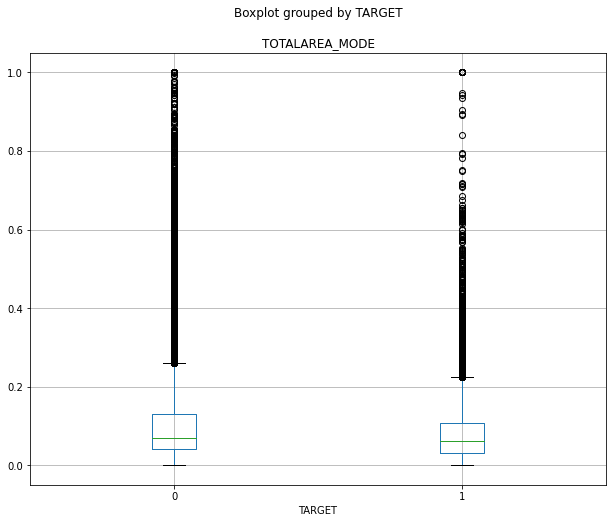

In [0]:
for col in residential_building_attributes:
  df.boxplot(by= 'TARGET', column=col)
  print("Average value of", col, "for defaulters (bad loans): ", df_bad[col].mean())
  print("Average value of", col, "for non-defaulters (good loans): ", df_good[col].mean())
  plt.show()

Overall, we can see a general trend that these attributes are higher for homes of non-defaulters. It seems people living in bigger and relatively newer homes with more facilities like elevators and more common area, appear to default less on their loans.

# break===================================================================================================================================

# Now lets look at the categorical columns, and how they affect the distribution of good and bad loans.

Lets first see the distribution by the type of loan, gender and income-type of borrower.

# NAME_CONTRACT_TYPE

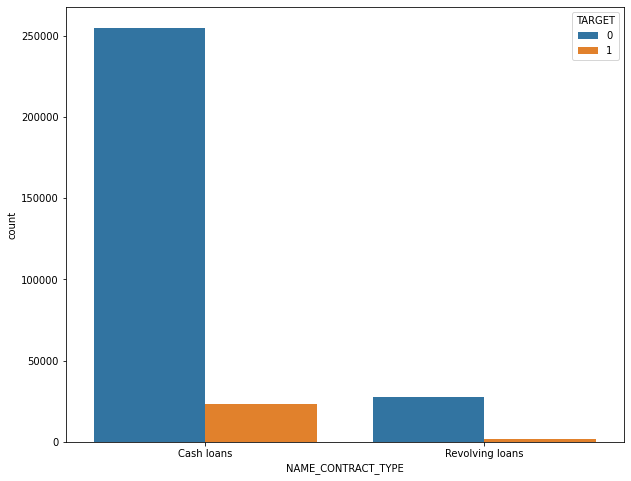

In [0]:
sns.countplot(df['NAME_CONTRACT_TYPE'], hue=target)

In [0]:
df['NAME_CONTRACT_TYPE'].value_counts()

Cash loans         278232
Revolving loans     29279
Name: NAME_CONTRACT_TYPE, dtype: int64

Number of applications for cash loans are much larger than revolving loans.

Revolving LOANS are the type of loans where the borrower can avail upto a pre-defined amount. Whenever he borrows from the limit, the applicable interest is charged, and his credit limit decreases by that amount. He has to repay the Principal and Interest within a specified time. After payment is received, the credit limit is replenished. Examples of revolving Loans are credit cards.

Lets find out the distribution of good and bad loans by 'NAME_CONTRACT_TYPE'

In [0]:
contingency_table = pd.crosstab(df['NAME_CONTRACT_TYPE'], df['TARGET'])
contingency_table

TARGET,0,1
NAME_CONTRACT_TYPE,,
Cash loans,255011,23221
Revolving loans,27675,1604


Defaulters ratio for Cash loans is 0.08345912763449208
Defaulters ratio for Revolving loans is 0.05478329177909082


Text(0, 0.5, 'Defaulters ratio -->')

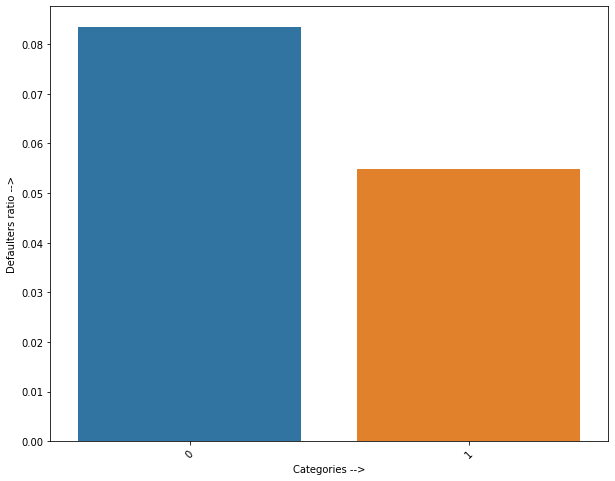

In [0]:
# finding the number of categories
num_of_categories = contingency_table.shape[0]

# calculating bad loans ratio for each category
ratio_by_category = np.empty(num_of_categories)
for i in range(num_of_categories):
  ratio_by_category[i] = contingency_table.iloc[i,1] / contingency_table.iloc[i,:].sum()
  print("Defaulters ratio for", contingency_table.index[i], "is", ratio_by_category[i])

# plotting the accpetance ratio by category
sns.barplot([j for j in range(num_of_categories)], ratio_by_category)
plt.xticks(range(num_of_categories), labels=contingency_table.columns, rotation=45)
plt.xlabel("Categories -->")
plt.ylabel("Defaulters ratio -->")

It seems that Cash loans are accepted more, but we will perform a chisquare test to evaluate the statistical significance of the above values.
perform permutation sampling and plot the distribution. See if the observed difference in the acceptance ratio is statistically significant.
Also perform chi-Square test.

Now we will check to see if observed difference of 0.033 is statistically significant using CHI-SQUARE TEST.

In [0]:
stat, p, dof, expected = scipy.stats.chi2_contingency(contingency_NAME_CONTRACT_TYPE)

In [0]:
type(stat), type(p), type(dof), type(expected)

(numpy.float64, numpy.float64, int, numpy.ndarray)

In [0]:
print("test statistic (chi-sqaure value =", stat)
print("p-value for the test statistic =", p)
print("Degrees of freedom = ", dof)
print("Expected frequencies = ", expected)

test statistic (chi-sqaure value = 293.15054219964554
p-value for the test statistic = 1.0235150721172847e-65
Degrees of freedom =  1
Expected frequencies =  [[255770.65910488  22461.34089512]
 [ 26915.34089512   2363.65910488]]


The value of chi-squared calculated is 293.15. This number seems to be large. Lets calculate the critical value, and see if the results are statistically significant. We will take alpha=0.05.

In [0]:
prob = 0.95
critical_value = scipy.stats.chi2.ppf(prob, dof)
critical_value

3.841458820694124

The calculated value is much greater than the chi square, hence, NAME_CONTRACT_TYPE is a significant predictor

# CODE_GENDER

Now let's see how the gender of the applicant is related to loan acceptance or rejection.

In [0]:
df['CODE_GENDER'].value_counts()

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

The number of female applicants is approximately twice the number of male applicants in HOME CREDIT database.

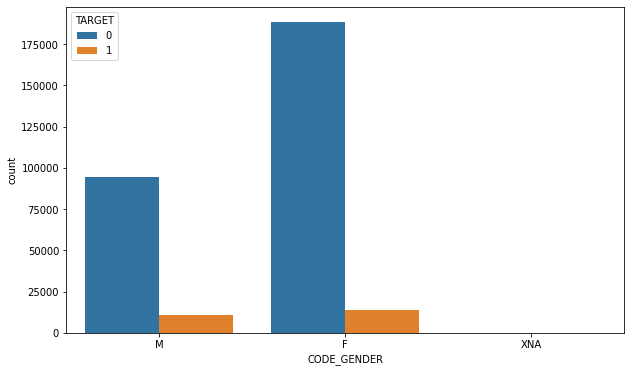

In [0]:
sns.countplot(df['CODE_GENDER'], hue = df['TARGET'])

In [0]:
contingency_CODE_GENDER = pd.crosstab(df['TARGET'], df['CODE_GENDER'])
contingency_CODE_GENDER

CODE_GENDER,F,M,XNA
TARGET,,,
0,188278,94404,4
1,14170,10655,0


The Gender 'XNA' may represent unavailability of data or a gender different than male or female. The number of observations is very small, hence they will not prove useful in our predictions. Lets calculate the acceptance ratio and rejection ratio by Male and Female applicants.

Acceptance ratio for F is 0.06999328222555916
Acceptance ratio for M is 0.1014192025433328
Acceptance ratio for XNA is 0.0


Text(0, 0.5, 'Loan accpetance ratio -->')

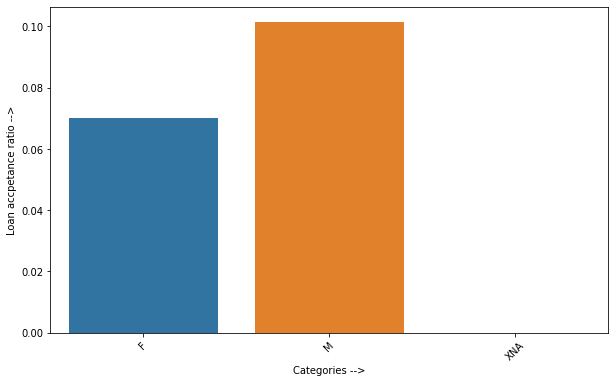

In [0]:
# finding the number of categories
num_of_categories = contingency_CODE_GENDER.shape[1]

# calculating acceptance ratio for each category
acceptance_CODE_GENDER = np.empty(num_of_categories)
for i in range(num_of_categories):
  acceptance_CODE_GENDER[i] = contingency_CODE_GENDER.iloc[1,i] / contingency_CODE_GENDER.iloc[:,i].sum()
  print("Acceptance ratio for", contingency_CODE_GENDER.columns[i], "is", acceptance_CODE_GENDER[i])

# plotting the accpetance ratio by category
sns.barplot([j for j in range(num_of_categories)], acceptance_CODE_GENDER)
plt.xticks(range(num_of_categories), labels=contingency_CODE_GENDER.columns, rotation=45)
plt.xlabel("Categories -->")
plt.ylabel("Loan accpetance ratio -->")

The acceptance ratio for Males seems to be much higher for females and other categories.  Lets perform chi-square test to see the statistical significance of Gender in predicting target.

As the Gender 'XNA' has ony 4 values, we cannot include this in the chi-square test as this test requires at least 5 values in each level of the category.

In [0]:
stat, p, dof, expected = scipy.stats.chi2_contingency(contingency_CODE_GENDER.drop('XNA', axis=1))

In [0]:
print("test statistic (chi-square value) =", stat)
print("p-value for the test statistic =", p)
print("Degrees of freedom = ", dof)
print("Expected frequencies = ", expected)

test statistic (chi-square value) = 920.0057254249849
p-value for the test statistic = 4.394091339983112e-202
Degrees of freedom =  1
Expected frequencies =  [[186104.39936652  96577.60063348]
 [ 16343.60063348   8481.39936652]]


The value of chi-squared calculated is 920.00. The p-value is practially ZERO. We can infer that this is a significant predictor. Lets calculate the critical value. We will take alpha=0.05.

In [0]:
prob = 0.95
critical_value = scipy.stats.chi2.ppf(prob, dof)
critical_value

3.841458820694124

The calculated value of 920 is much higher than the critical value of 3.84. Hence, Gender is a significant variable in prediction of target.

# NAME_INCOME_TYPE

In loan application process, the income of a borrower is one of the most critical factors in deciding acceptance or rejection of application.  Lets see how the Income Type of the applicant is related to acceptance or rejection.

In [0]:
df['NAME_INCOME_TYPE'].value_counts()

Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: NAME_INCOME_TYPE, dtype: int64

Applications by working persons is the most common in our database. Applications by students, businessmen, unemployed persons and females on maternity leave are very few.

Lets plot and see the distribution.

In [0]:
contingency_INCOME_TYPE = pd.crosstab(df['TARGET'], df['NAME_INCOME_TYPE'])
contingency_INCOME_TYPE

NAME_INCOME_TYPE,Businessman,Commercial associate,Maternity leave,Pensioner,State servant,Student,Unemployed,Working
TARGET,,,,,,,,
0,10,66257,3,52380,20454,18,14,143550
1,0,5360,2,2982,1249,0,8,15224


([<matplotlib.axis.XTick at 0x7fd104393128>,
 [Text(0, 0, 'Businessman'),
  Text(0, 0, 'Commercial associate'),
  Text(0, 0, 'Maternity leave'),
  Text(0, 0, 'Pensioner'),
  Text(0, 0, 'State servant'),
  Text(0, 0, 'Student'),
  Text(0, 0, 'Unemployed'),
  Text(0, 0, 'Working')])

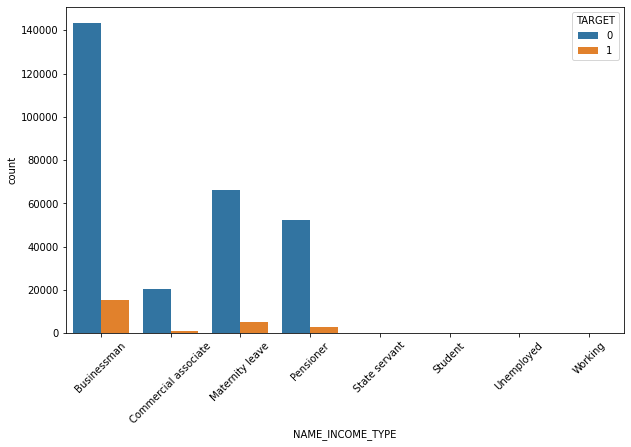

In [0]:
plt.figure(figsize=(10,6))
sns.countplot(df['NAME_INCOME_TYPE'], hue = df['TARGET'])
plt.xticks(range(contingency_INCOME_TYPE.shape[1]), contingency_INCOME_TYPE.columns, rotation = 45)

As we can see, the applications mainly consist of those by working people, state servants, commercial associates and pensioners. Number of applications by other categories are very few.

Using frequencies from above contingecy table, we can calculate the accpetance ratio by each category of income type

Lets plot the acceptance ratio by income type and see the trend.


In [0]:
# finding the number of categories
num_of_categories = contingency_INCOME_TYPE.shape[1]

# calculating accpetance ratio for each category
acceptance_INCOME_TYPE = np.empty(num_of_categories)
for i in range(num_of_categories):
  acceptance_INCOME_TYPE[i] = contingency_INCOME_TYPE.iloc[1,i] / contingency_INCOME_TYPE.iloc[:,i].sum()
  print("Acceptance ratio for", contingency_INCOME_TYPE.columns[i], "is", acceptance_INCOME_TYPE[i])

Acceptance ratio for Businessman is 0.0
Acceptance ratio for Commercial associate is 0.07484256531270508
Acceptance ratio for Maternity leave is 0.4
Acceptance ratio for Pensioner is 0.053863660994906255
Acceptance ratio for State servant is 0.05754964751416855
Acceptance ratio for Student is 0.0
Acceptance ratio for Unemployed is 0.36363636363636365
Acceptance ratio for Working is 0.09588471664126369


([<matplotlib.axis.XTick at 0x7fd102637cc0>,
 [Text(0, 0, 'Businessman'),
  Text(0, 0, 'Commercial associate'),
  Text(0, 0, 'Maternity leave'),
  Text(0, 0, 'Pensioner'),
  Text(0, 0, 'State servant'),
  Text(0, 0, 'Student'),
  Text(0, 0, 'Unemployed'),
  Text(0, 0, 'Working')])

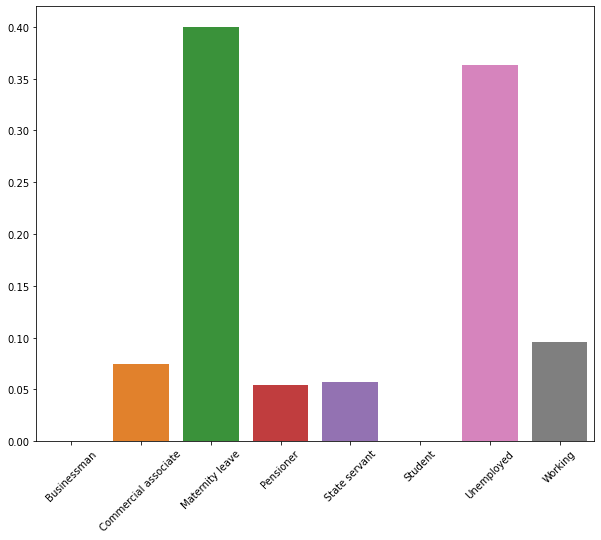

In [0]:
# plotting the data
sns.barplot([j for j in range(num_of_categories)], acceptance_INCOME_TYPE)
plt.xticks(range(num_of_categories), labels=contingency_INCOME_TYPE.columns, rotation=45)

INTERESTING OBSERVATION - Acceptance ratio of unemployed persons is higher than that of Pensioner, Working people, and State servant !!! This is peculiar, but may be due to other factors of the HOME CREDIT loan appraisal process.

The acceptance ratio of applicants on maternity leave is the highest. But since we have only 5 applications in this category, we cannot conclusively infer anything.

Students and Business men have NO accepted loans.



Lets perform the CHI-SQUARE test to find out the significance of this predictor for target.

In [0]:
stat, p, dof, expected = scipy.stats.chi2_contingency(contingency_INCOME_TYPE)

In [0]:
print("test statistic (chi-sqaure value =", stat)
print("p-value for the test statistic =", p)
print("Degrees of freedom = ", dof)
print("Expected frequencies = ", expected)

test statistic (chi-sqaure value = 1253.4708080924988
p-value for the test statistic = 1.9281456056858933e-266
Degrees of freedom =  7
Expected frequencies =  [[9.19271181e+00 6.58354441e+04 4.59635590e+00 5.08926911e+04
  1.99509424e+04 1.65468812e+01 2.02239660e+01 1.45956362e+05]
 [8.07288195e-01 5.78155586e+03 4.03644097e-01 4.46930890e+03
  1.75205757e+03 1.45311875e+00 1.77603403e+00 1.28176376e+04]]


The value of chi-squared calculated is 293.15. This number seems to be large. Lets calculate the critical value, and see if the results are statistically significant. We will take alpha=0.05.

In [0]:
prob = 0.95
critical_value = scipy.stats.chi2.ppf(prob, dof)
critical_value

14.067140449340169

The calculated value is much greater than the critical value, hence NAME_CONTRACT_TYPE is a significant predictor

# CNT_CHILDREN

This column represents the number of children of the applicants.

In [0]:
children_value_counts = df['CNT_CHILDREN'].value_counts()
children_value_counts.cumsum()

0     215371
1     276490
2     303239
3     306956
4     307385
5     307469
6     307490
7     307497
14    307500
19    307502
12    307504
10    307506
9     307508
8     307510
11    307511
Name: CNT_CHILDREN, dtype: int64

About 99.8% applicants have less than three children. Borrowers having more than 3 children are very uncommon.

In [0]:
contingency_CNT_CHILDREN = pd.crosstab(df['CNT_CHILDREN'], df['TARGET'])
contingency_CNT_CHILDREN

TARGET,0,1
CNT_CHILDREN,,
0,198762,16609
1,55665,5454
2,24416,2333
3,3359,358
4,374,55
5,77,7
6,15,6
7,7,0
8,2,0


In [0]:
bad_loans_children = np.array(contingency_CNT_CHILDREN[1])
good_loans_children = np.array(contingency_CNT_CHILDREN[0])
total = bad_loans_children + good_loans_children
contingency_CNT_CHILDREN['Percentage_bad_loans'] = bad_loans_children / total
contingency_CNT_CHILDREN['Percentage_good_loans'] = good_loans_children / total

In [0]:
contingency_CNT_CHILDREN

TARGET,0,1,Percentage_bad_loans,Percentage_good_loans
CNT_CHILDREN,,,,
0,198762,16609,0.077118,0.922882
1,55665,5454,0.089236,0.910764
2,24416,2333,0.087218,0.912782
3,3359,358,0.096314,0.903686
4,374,55,0.128205,0.871795
5,77,7,0.083333,0.916667
6,15,6,0.285714,0.714286
7,7,0,0.000000,1.000000
8,2,0,0.000000,1.000000


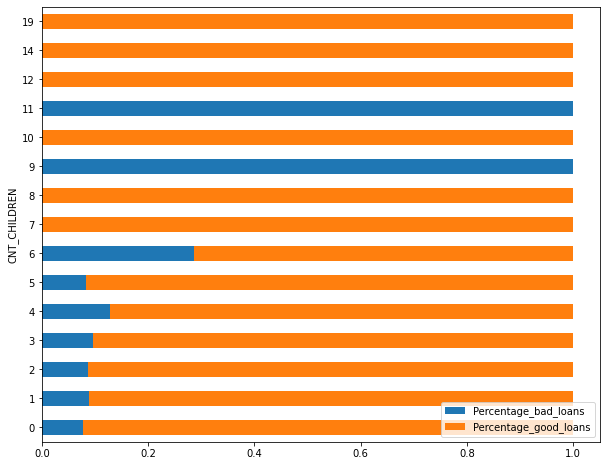

In [0]:
contingency_CNT_CHILDREN[['Percentage_bad_loans','Percentage_good_loans']].plot(kind='barh', stacked=True)
plt.legend(loc='lower right')

Borrowers with more than 4 children are very uncommmon, hence its not possible to comment on the default rate trend. For borrowers with less than 4 children, the default rates are fairly uniform.

# EDUCATION TYPE



In [0]:
df['NAME_EDUCATION_TYPE'].value_counts()

Secondary / secondary special    218391
Higher education                  74863
Incomplete higher                 10277
Lower secondary                    3816
Academic degree                     164
Name: NAME_EDUCATION_TYPE, dtype: int64

About two-thirds of the applicants are have upto secondary education. Applicants with higher education are also common.

We will plot the data.

In [0]:
contingency_NAME_EDUCATION_TYPE = pd.crosstab(df['NAME_EDUCATION_TYPE'], df['TARGET'])
contingency_NAME_EDUCATION_TYPE

TARGET,0,1
NAME_EDUCATION_TYPE,,
Academic degree,161,3
Higher education,70854,4009
Incomplete higher,9405,872
Lower secondary,3399,417
Secondary / secondary special,198867,19524


([<matplotlib.axis.XTick at 0x7fd1032bc8d0>,
 [Text(0, 0, 'Academic degree'),
  Text(0, 0, 'Higher education'),
  Text(0, 0, 'Incomplete higher'),
  Text(0, 0, 'Lower secondary'),
  Text(0, 0, 'Secondary / secondary special')])

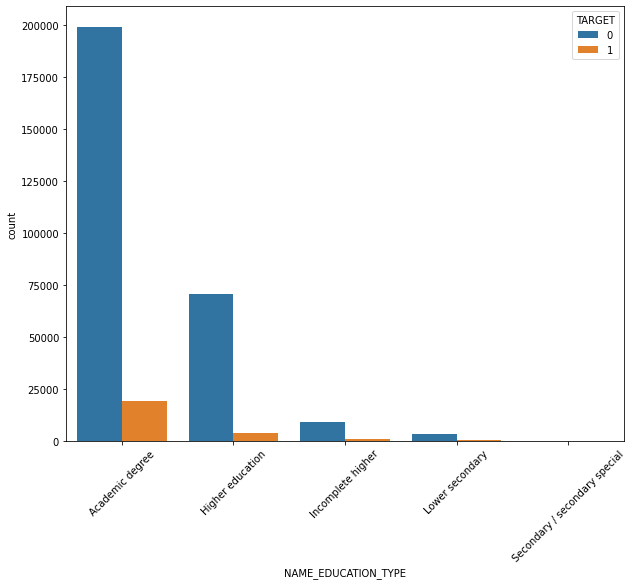

In [0]:
sns.countplot(df['NAME_EDUCATION_TYPE'], hue=df['TARGET'])
plt.xticks(range(contingency_NAME_EDUCATION_TYPE.shape[0]), contingency_NAME_EDUCATION_TYPE.index, rotation = 45)

In [0]:
bad_loans = np.array(contingency_NAME_EDUCATION_TYPE[1])
good_loans = np.array(contingency_NAME_EDUCATION_TYPE[0])
total = bad_loans + good_loans
contingency_NAME_EDUCATION_TYPE['Percentage_bad_loans'] = bad_loans / total
contingency_NAME_EDUCATION_TYPE['Percentage_good_loans'] = good_loans / total

In [0]:
contingency_NAME_EDUCATION_TYPE

TARGET,0,1,Percentage_bad_loans,Percentage_good_loans
NAME_EDUCATION_TYPE,,,,
Academic degree,161,3,0.018293,0.981707
Higher education,70854,4009,0.053551,0.946449
Incomplete higher,9405,872,0.084850,0.915150
Lower secondary,3399,417,0.109277,0.890723
Secondary / secondary special,198867,19524,0.089399,0.910601


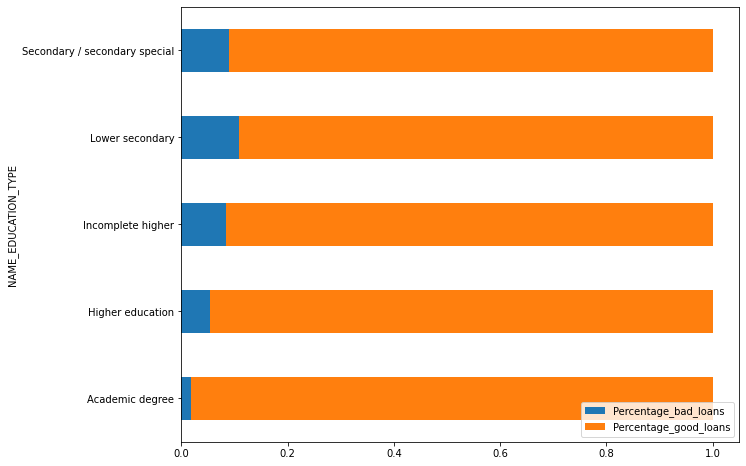

In [0]:
contingency_NAME_EDUCATION_TYPE[['Percentage_bad_loans','Percentage_good_loans']].plot(kind='barh', stacked=True)
plt.legend(loc='lower right')


Also perform chi-Square test.

In [0]:
stat, p, dof, expected = scipy.stats.chi2_contingency(contingency_NAME_EDUCATION_TYPE)

In [0]:
type(stat), type(p), type(dof), type(expected)

(numpy.float64, numpy.float64, int, numpy.ndarray)

In [0]:
print("test statistic (chi-sqaure value =", stat)
print("p-value for the test statistic =", p)
print("Degrees of freedom = ", dof)
print("Expected frequencies = ", expected)

test statistic (chi-sqaure value = 293.15054219964554
p-value for the test statistic = 1.0235150721172847e-65
Degrees of freedom =  1
Expected frequencies =  [[255770.65910488  22461.34089512]
 [ 26915.34089512   2363.65910488]]


The value of chi-squared calculated is 293.15. This number seems to be large. Lets calculate the critical value, and see if the results are statistically significant. We will take alpha=0.05.

In [0]:
prob = 0.95
critical_value = scipy.stats.chi2.ppf(prob, dof)
critical_value

3.841458820694124

The calculated value is much greater than the chi square, hence, NAME_CONTRACT_TYPE is a significant predictor

# FLAG_OWN_CAR

In [0]:
df['FLAG_OWN_CAR'].value_counts()

N    202924
Y    104587
Name: FLAG_OWN_CAR, dtype: int64

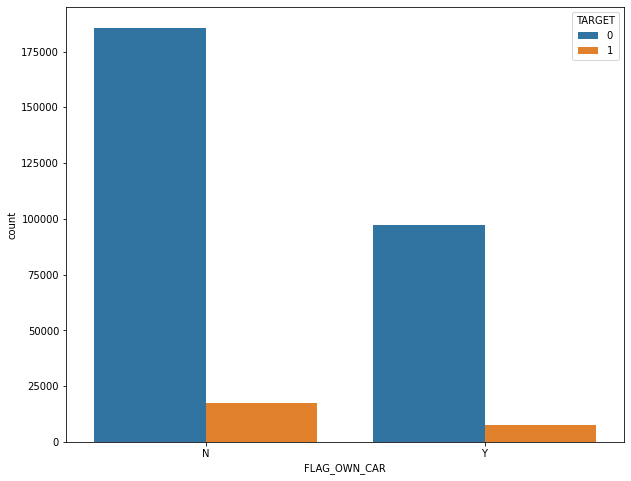

In [0]:
sns.countplot(x=df['FLAG_OWN_CAR'], hue=df['TARGET'])

In [0]:
contingency_table = pd.crosstab(df['FLAG_OWN_CAR'], df['TARGET'])
contingency_table

TARGET,0,1
FLAG_OWN_CAR,,
N,185675,17249
Y,97011,7576


In [0]:
bad_loans = np.array(contingency_table[1])
good_loans = np.array(contingency_table[0])
total = bad_loans + good_loans
contingency_table['Percentage_bad_loans'] = bad_loans / total
contingency_table['Percentage_good_loans'] = good_loans / total

In [0]:
contingency_table

TARGET,0,1,Percentage_bad_loans,Percentage_good_loans
FLAG_OWN_CAR,,,,
N,185675,17249,0.085002,0.914998
Y,97011,7576,0.072437,0.927563


The defaulters ratio for borrowers with and without a car, are very close. There is only a minuscle difference.

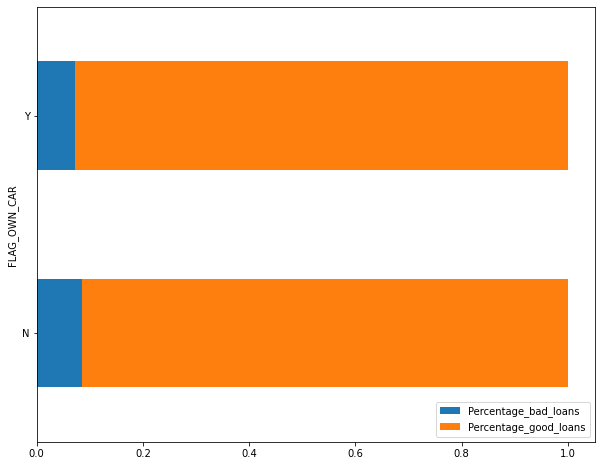

In [0]:
contingency_table[['Percentage_bad_loans','Percentage_good_loans']].plot(kind='barh', stacked=True)
plt.legend(loc='lower right')

# FLAG_OWN_REALTY

In [0]:
contingency_table = pd.crosstab(df['FLAG_OWN_REALTY'], df['TARGET'])
contingency_table

TARGET,0,1
FLAG_OWN_REALTY,,
N,86357,7842
Y,196329,16983


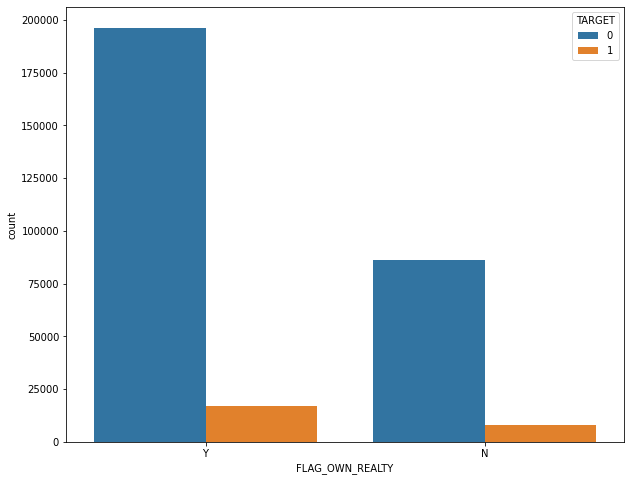

In [0]:
sns.countplot(df['FLAG_OWN_REALTY'], hue=df['TARGET'])

Overall, there are more people with own homes, than without.

In [0]:
bad_loans = np.array(contingency_table[1])
good_loans = np.array(contingency_table[0])
total = bad_loans + good_loans
contingency_table['Percentage_bad_loans'] = bad_loans / total
contingency_table['Percentage_good_loans'] = good_loans / total

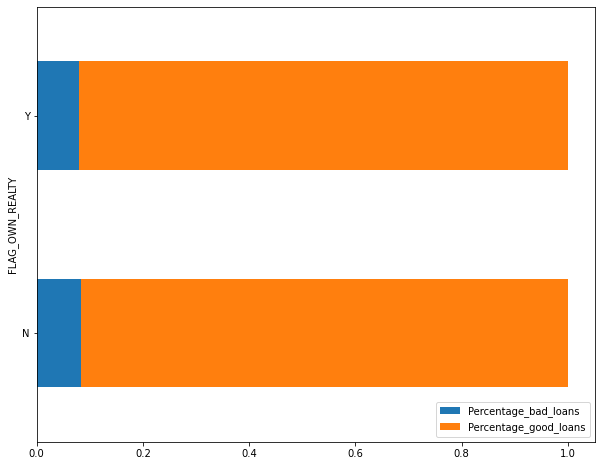

In [0]:
contingency_table[['Percentage_bad_loans','Percentage_good_loans']].plot(kind='barh', stacked=True)
plt.legend(loc='lower right')

There seems to be no difference  in the default rate of people with own homes and without own homes.

# NAME_TYPE_SUITE

In [0]:
contingency_table = pd.crosstab(df['NAME_TYPE_SUITE'], df['TARGET'])
contingency_table

TARGET,0,1
NAME_TYPE_SUITE,,
Children,3026,241
Family,37140,3009
Group of people,248,23
Other_A,790,76
Other_B,1596,174
"Spouse, partner",10475,895
Unaccompanied,228189,20337


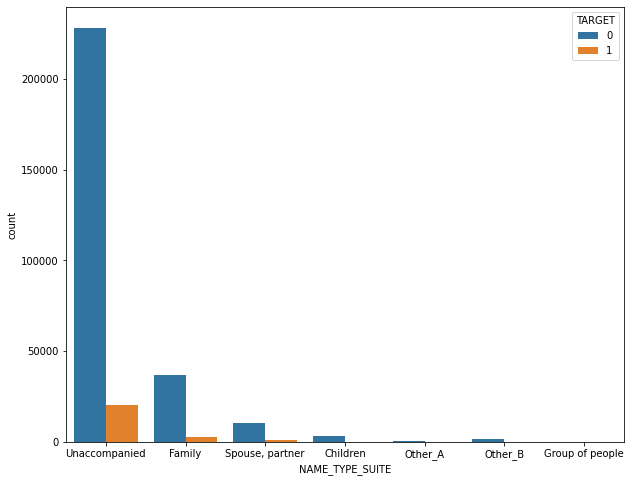

In [0]:
sns.countplot(df['NAME_TYPE_SUITE'], hue=df['TARGET'])

Most borrowers had come alone for the application. Does this mean more default ? Lets find out.



In [0]:
bad_loans = np.array(contingency_table[1])
good_loans = np.array(contingency_table[0])
total = bad_loans + good_loans
contingency_table['Percentage_bad_loans'] = (bad_loans * 100.0) / total
contingency_table['Percentage_good_loans'] = (good_loans * 100.0)/ total

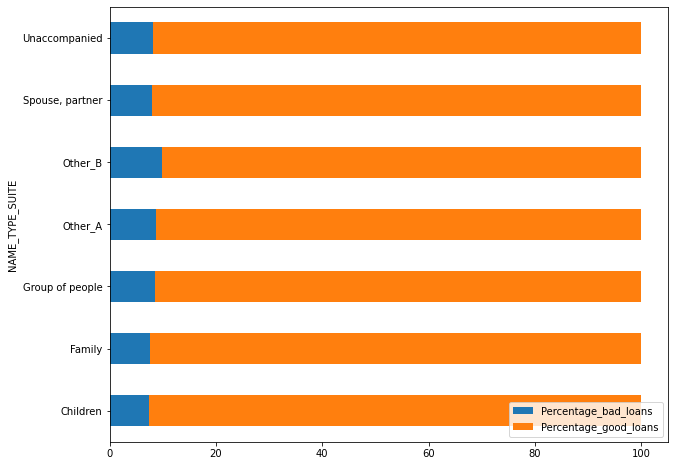

In [0]:
contingency_table[['Percentage_bad_loans','Percentage_good_loans']].plot(kind='barh', stacked=True)
plt.legend(loc='lower right')

There is no pronunced difference in the default rate for various categories.

# NAME_FAMILY_STATUS

In [0]:
contingency_table = pd.crosstab(df['NAME_FAMILY_STATUS'], df['TARGET'])
contingency_table

TARGET,0,1
NAME_FAMILY_STATUS,,
Civil marriage,26814,2961
Married,181582,14850
Separated,18150,1620
Single / not married,40987,4457
Unknown,2,0
Widow,15151,937


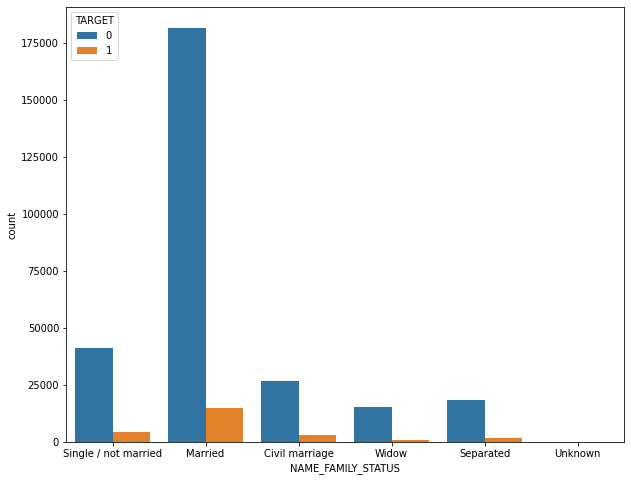

In [0]:
sns.countplot(df['NAME_FAMILY_STATUS'], hue=df['TARGET'])

Loans to married persons are the  most common.


In [0]:
bad_loans = np.array(contingency_table[1])
good_loans = np.array(contingency_table[0])
total = bad_loans + good_loans
contingency_table['Percentage_bad_loans'] = (bad_loans * 100.0) / total
contingency_table['Percentage_good_loans'] = (good_loans * 100.0)/ total

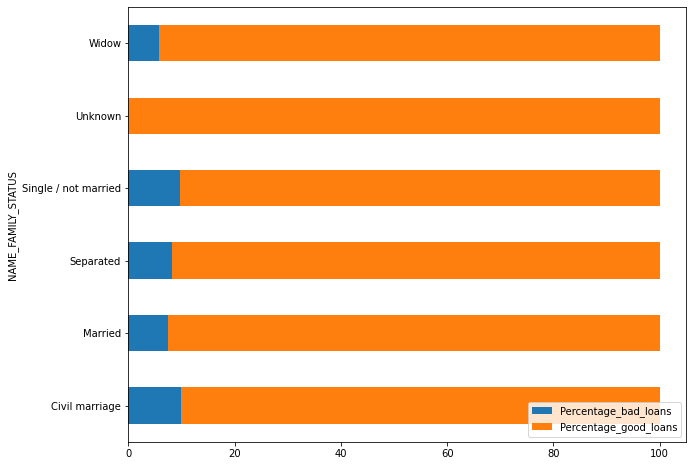

In [0]:
contingency_table[['Percentage_bad_loans','Percentage_good_loans']].plot(kind='barh', stacked=True)
plt.legend(loc='lower right')

Default rates are more or less similar across categories. Defaults by singles and people with civil marriage are relatively higher.

# NAME_HOUSING_TYPE

In [0]:
contingency_table = pd.crosstab(df['NAME_HOUSING_TYPE'], df['TARGET'])
contingency_table

TARGET,0,1
NAME_HOUSING_TYPE,,
Co-op apartment,1033,89
House / apartment,251596,21272
Municipal apartment,10228,955
Office apartment,2445,172
Rented apartment,4280,601
With parents,13104,1736


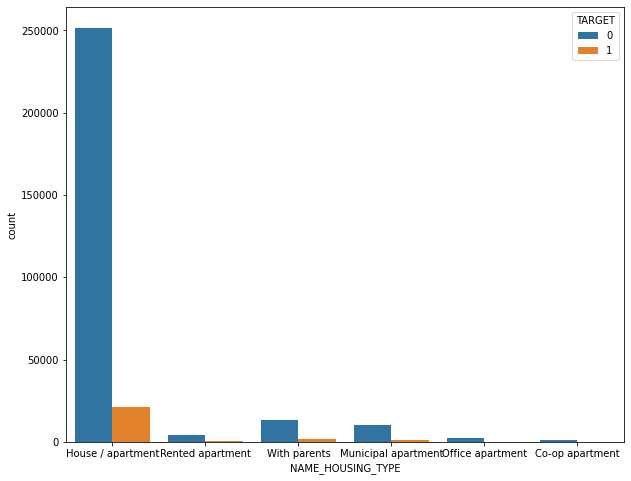

In [0]:
sns.countplot(df['NAME_HOUSING_TYPE'], hue=df['TARGET'])

In [0]:
bad_loans = np.array(contingency_table[1])
good_loans = np.array(contingency_table[0])
total = bad_loans + good_loans
contingency_table['Percentage_bad_loans'] = (bad_loans * 100.0) / total
contingency_table['Percentage_good_loans'] = (good_loans * 100.0)/ total

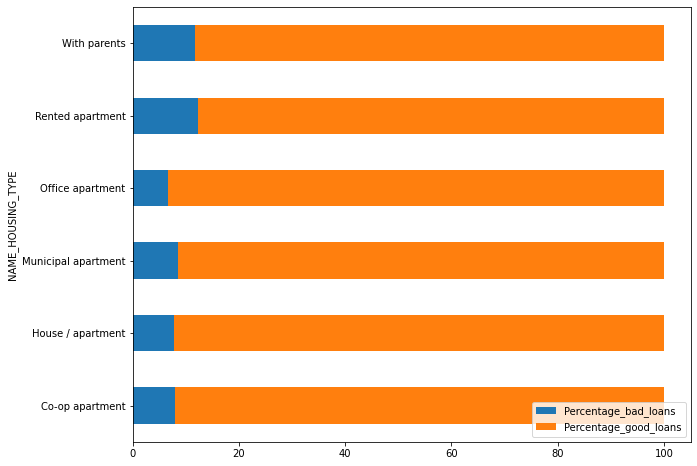

In [0]:
contingency_table[['Percentage_bad_loans','Percentage_good_loans']].plot(kind='barh', stacked=True)
plt.legend(loc='lower right')

People living with parents and in rented apartments seem to have higher default rates. This may be due to weak financial status.

# FLAG_MOBIL

In [0]:
contingency_table = pd.crosstab(df['FLAG_MOBIL'], df['TARGET'])
contingency_table

TARGET,0,1
FLAG_MOBIL,,
0,1,0
1,282685,24825


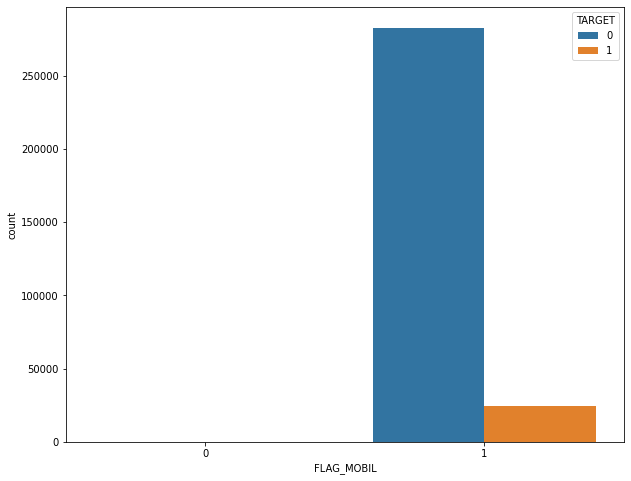

In [0]:
sns.countplot(df['FLAG_MOBIL'], hue=df['TARGET'])

There is ony 1 person who did not provide mobile phone number. Hence,we can drop this column.




# FLAG_EMP_PHONE

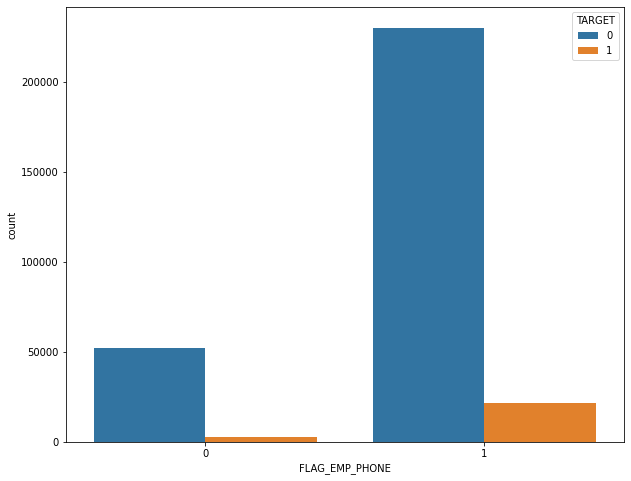

In [0]:
sns.countplot(df['FLAG_EMP_PHONE'], hue=df['TARGET'])

In [0]:
contingency_table = pd.crosstab(df['FLAG_EMP_PHONE'], df['TARGET'])
bad_loans = np.array(contingency_table[1])
good_loans = np.array(contingency_table[0])
total = bad_loans + good_loans
contingency_table['Percentage_bad_loans'] = (bad_loans * 100.0) / total
contingency_table['Percentage_good_loans'] = (good_loans * 100.0)/ total

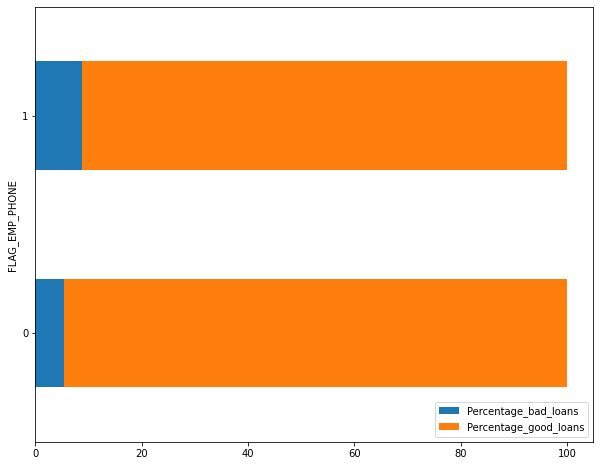

In [0]:
contingency_table[['Percentage_bad_loans','Percentage_good_loans']].plot(kind='barh', stacked=True)
plt.legend(loc='lower right')

This does not seem to be a strong differentiator between good and bad loans

# FLAG_WORK_PHONE

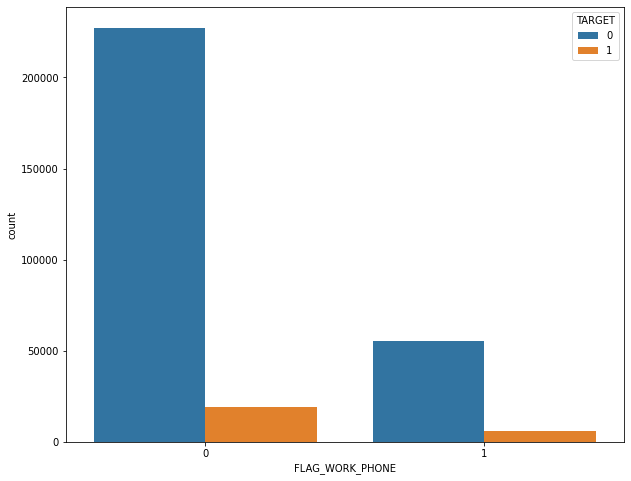

In [0]:
sns.countplot(df['FLAG_WORK_PHONE'], hue=df['TARGET'])

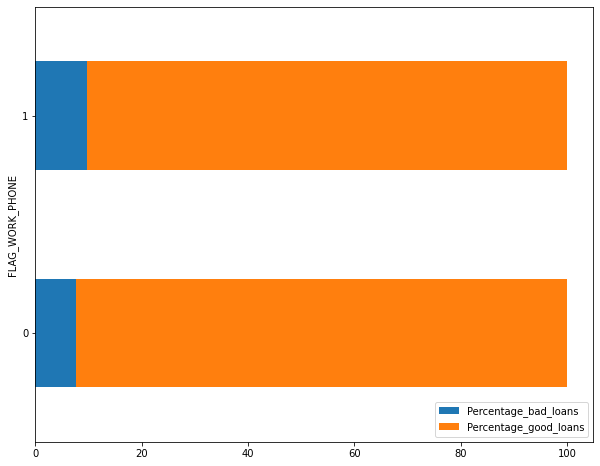

In [0]:
# creating contingency table
contingency_table = pd.crosstab(df['FLAG_WORK_PHONE'], df['TARGET'])
bad_loans = np.array(contingency_table[1])
good_loans = np.array(contingency_table[0])
total = bad_loans + good_loans
contingency_table['Percentage_bad_loans'] = (bad_loans * 100.0) / total
contingency_table['Percentage_good_loans'] = (good_loans * 100.0)/ total

#plotting the bar chart
contingency_table[['Percentage_bad_loans','Percentage_good_loans']].plot(kind='barh', stacked=True)
plt.legend(loc='lower right')

Again, there isn't much difference between defaulters and non-defaulters.

# FLAG_CONT_MOBILE

TARGET,0,1
FLAG_CONT_MOBILE,,
0,529,45
1,282157,24780


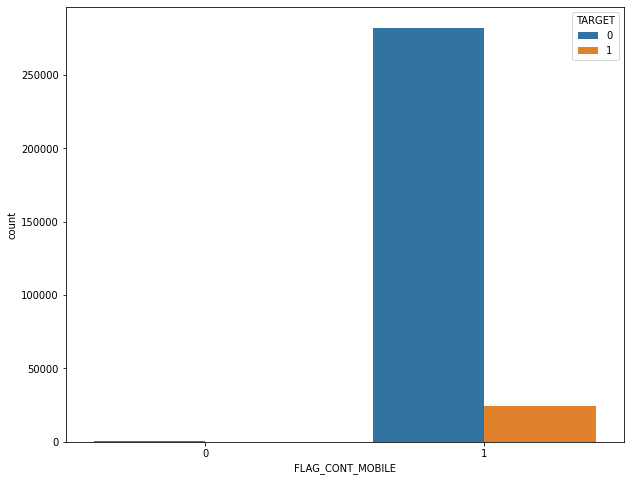

In [0]:
sns.countplot(df['FLAG_CONT_MOBILE'], hue=df['TARGET'])
contingency_table = pd.crosstab(df['FLAG_CONT_MOBILE'], df['TARGET'])
contingency_table

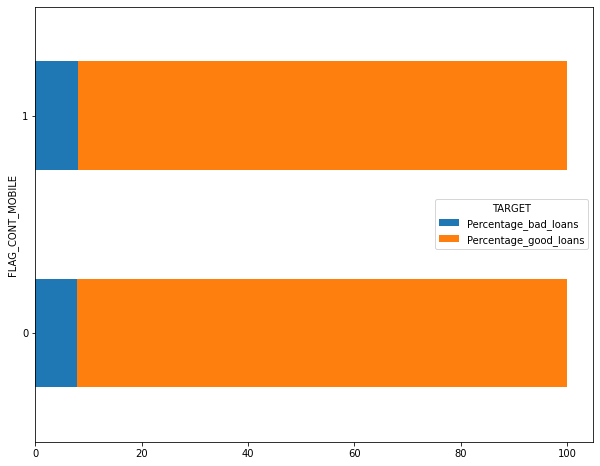

In [0]:
bad_loans = np.array(contingency_table[1])
good_loans = np.array(contingency_table[0])
total = bad_loans + good_loans
contingency_table['Percentage_bad_loans'] = (bad_loans * 100.0) / total
contingency_table['Percentage_good_loans'] = (good_loans * 100.0)/ total
contingency_table[['Percentage_bad_loans','Percentage_good_loans']].plot(kind='barh', stacked=True)

# FLAG_EMAIL

TARGET,0,1
FLAG_EMAIL,,
0,266618,23451
1,16068,1374


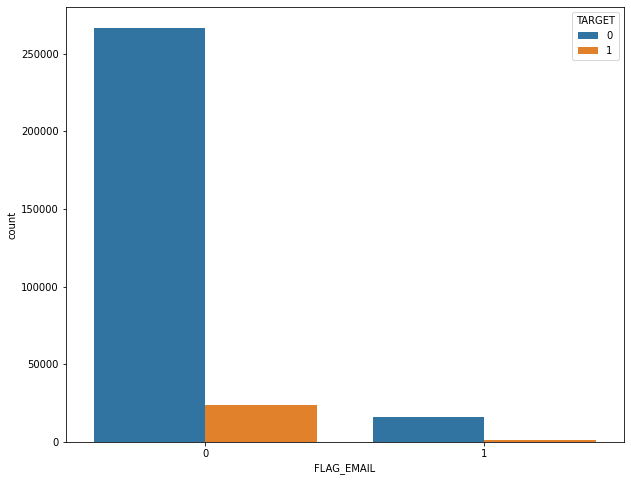

In [0]:
sns.countplot(df['FLAG_EMAIL'], hue=df['TARGET'])
contingency_table = pd.crosstab(df['FLAG_EMAIL'], df['TARGET'])
contingency_table

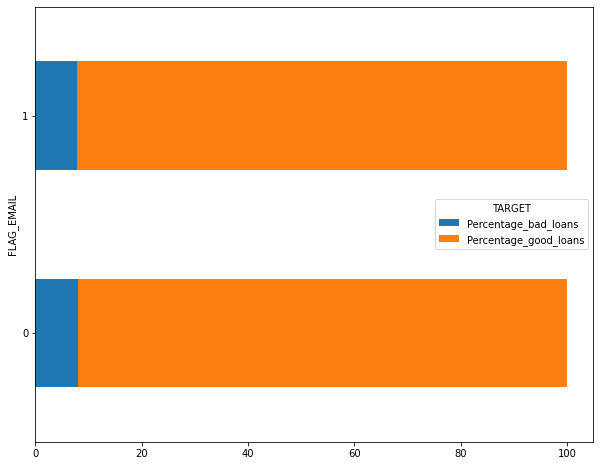

In [0]:
bad_loans = np.array(contingency_table[1])
good_loans = np.array(contingency_table[0])
total = bad_loans + good_loans
contingency_table['Percentage_bad_loans'] = (bad_loans * 100.0) / total
contingency_table['Percentage_good_loans'] = (good_loans * 100.0)/ total
contingency_table[['Percentage_bad_loans','Percentage_good_loans']].plot(kind='barh', stacked=True)

# OCCUPATION_TYPE

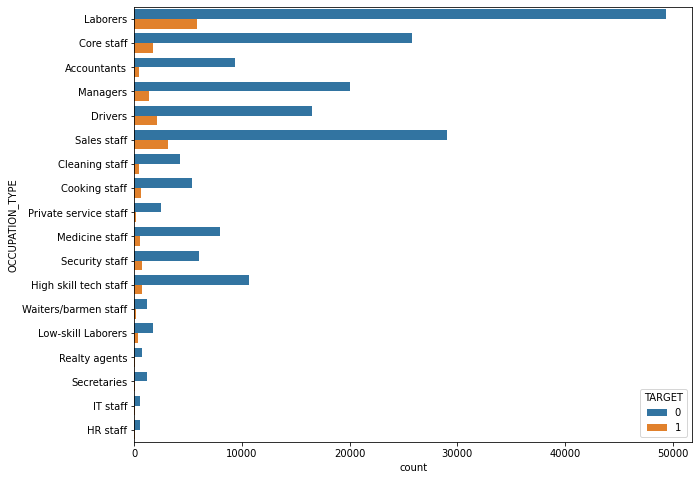

In [0]:
sns.countplot(y=df['OCCUPATION_TYPE'], hue=df['TARGET'])

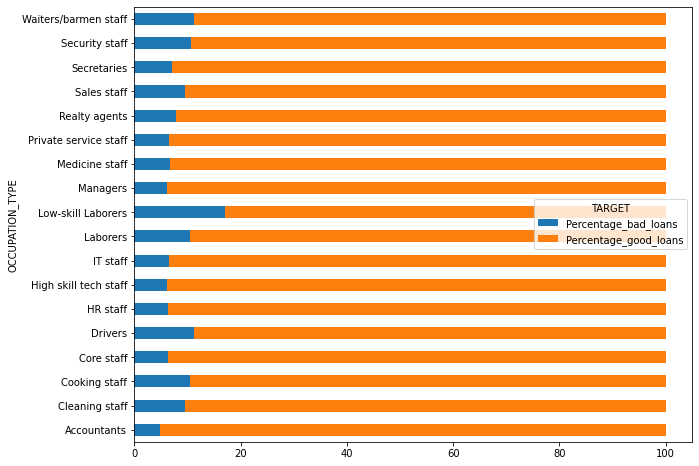

In [0]:
contingency_table = pd.crosstab(df['OCCUPATION_TYPE'], df['TARGET'])
bad_loans = np.array(contingency_table[1])
good_loans = np.array(contingency_table[0])
total = bad_loans + good_loans
contingency_table['Percentage_bad_loans'] = (bad_loans * 100.0) / total
contingency_table['Percentage_good_loans'] = (good_loans * 100.0)/ total
contingency_table[['Percentage_bad_loans','Percentage_good_loans']].plot(kind='barh', stacked=True)

Low-skill workers like labourers, cleaning staff, cooking staff, and barmen seem to have a higher tendency to default on their loans.

# CNT_FAM_MEMBERS

In [0]:
contingency_table = pd.crosstab(df['CNT_FAM_MEMBERS'], df['TARGET'])
contingency_table

TARGET,0,1
CNT_FAM_MEMBERS,,
1.0,62172,5675
2.0,146348,12009
3.0,47993,4608
4.0,22561,2136
5.0,3151,327
6.0,353,55
7.0,75,6
8.0,14,6
9.0,6,0


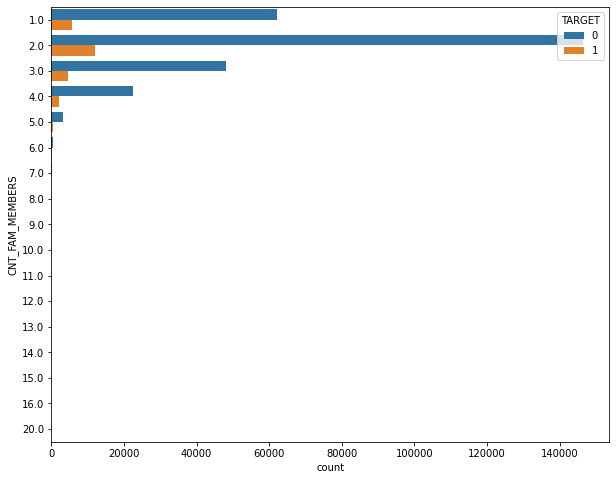

In [0]:
sns.countplot(y=df['CNT_FAM_MEMBERS'], hue=df['TARGET'])

Borrowers with more than 4 family members are extremely rare.

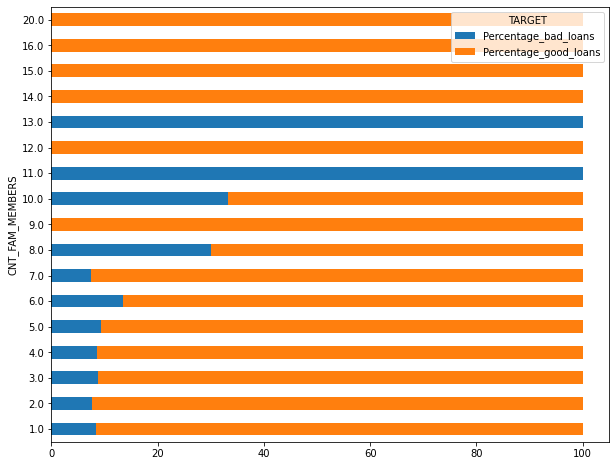

In [0]:
bad_loans = np.array(contingency_table[1])
good_loans = np.array(contingency_table[0])
total = bad_loans + good_loans
contingency_table['Percentage_bad_loans'] = (bad_loans * 100.0) / total
contingency_table['Percentage_good_loans'] = (good_loans * 100.0)/ total
contingency_table[['Percentage_bad_loans','Percentage_good_loans']].plot(kind='barh', stacked=True)

Default rates for borrowers with upto 4 family members are quite similar. For people with larger families, we have too less data to comment on the default rates.

# REGION_RATING_CLIENT

This is an internal rating given by Home Credit to the region where the borrower lives.

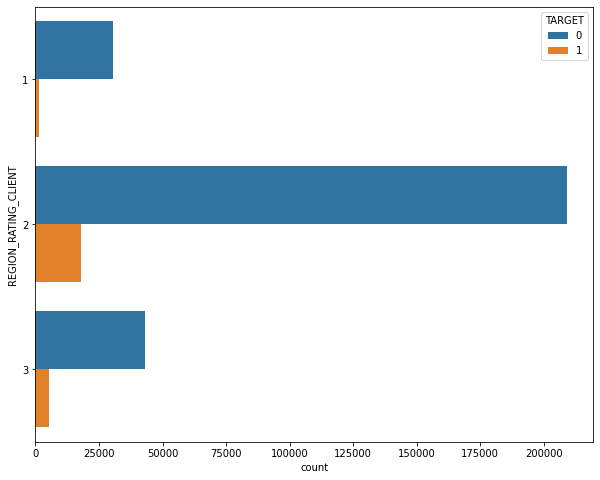

In [16]:
sns.countplot(y=df['REGION_RATING_CLIENT'], hue=df['TARGET'])

In [0]:
contingency_table = pd.crosstab(df['REGION_RATING_CLIENT'], df['TARGET'])

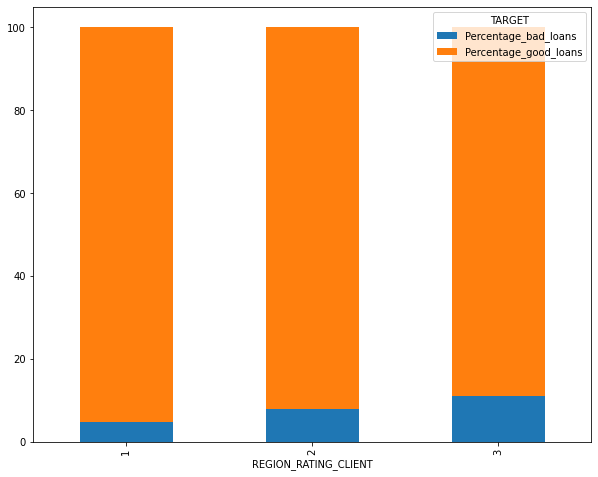

In [19]:
bad_loans = np.array(contingency_table[1])
good_loans = np.array(contingency_table[0])
total = bad_loans + good_loans
contingency_table['Percentage_bad_loans'] = (bad_loans * 100.0) / total
contingency_table['Percentage_good_loans'] = (good_loans * 100.0)/ total
contingency_table[['Percentage_bad_loans','Percentage_good_loans']].plot(kind='bar', stacked=True)

Clients of Region Category 3 tend to default the most (as seen in our dataset).

The highest number of borrowers are from region category - 2.

# REGION_RATING_CLIENT_W_CITY

Rating of borrowers REGION, taking his/he city into consideration too.

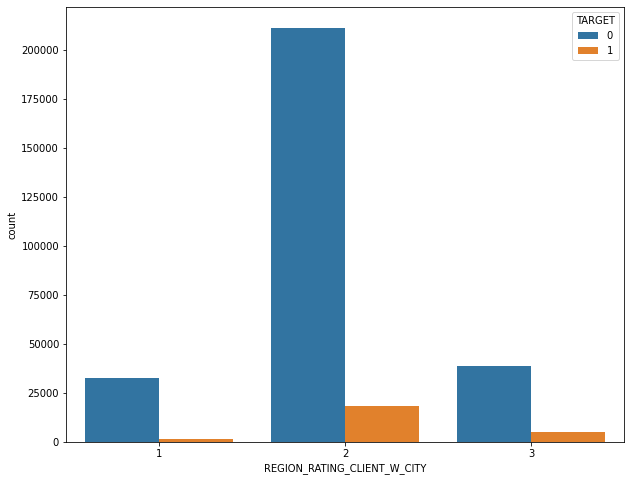

In [21]:
sns.countplot(x=df['REGION_RATING_CLIENT_W_CITY'], hue=df['TARGET'])

Here again, Region category is the most common.

In [0]:
contingency_table = pd.crosstab(df['REGION_RATING_CLIENT_W_CITY'], df['TARGET'])

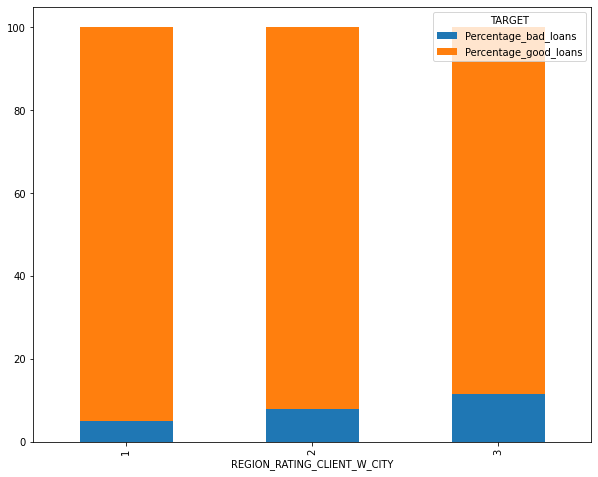

In [23]:
bad_loans = np.array(contingency_table[1])
good_loans = np.array(contingency_table[0])
total = bad_loans + good_loans
contingency_table['Percentage_bad_loans'] = (bad_loans * 100.0) / total
contingency_table['Percentage_good_loans'] = (good_loans * 100.0)/ total
contingency_table[['Percentage_bad_loans','Percentage_good_loans']].plot(kind='bar', stacked=True)

Again, we see highest default rates in clients of Region category 3.

# WEEKDAY_APPR_PROCESS_START

On which day of the week did the client apply for the loan. This is an interesting variable. Defaults should not be affected by the day when the application started, because it is a trivial variable. But lets see if our assumption is true.

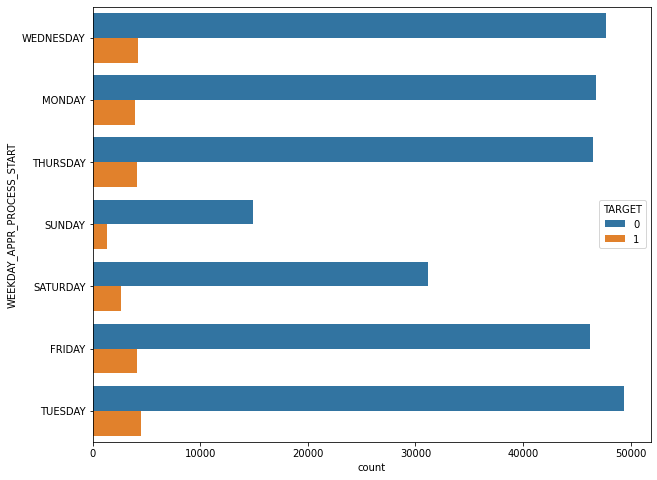

In [24]:
sns.countplot(y=df['WEEKDAY_APPR_PROCESS_START'], hue=df['TARGET'])

As expected, weekends have the least number of applications.

In [0]:
contingency_table = pd.crosstab(df['WEEKDAY_APPR_PROCESS_START'], df['TARGET'])

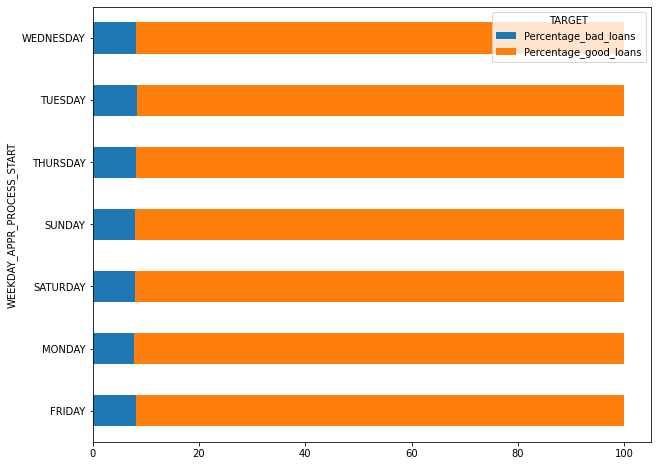

In [26]:
bad_loans = np.array(contingency_table[1])
good_loans = np.array(contingency_table[0])
total = bad_loans + good_loans
contingency_table['Percentage_bad_loans'] = (bad_loans * 100.0) / total
contingency_table['Percentage_good_loans'] = (good_loans * 100.0)/ total
contingency_table[['Percentage_bad_loans','Percentage_good_loans']].plot(kind='barh', stacked=True)

The results confirm what we assumed !!

The default rates across all weekdays of application are similar. This also helps us to think about the effects of other categorical variables, where we saw a minute difference in the default rates. Thus we need to consider even small differences for our modelling.

# HOUR_APPR_PROCESS_START

Approximately at what hour did the client apply for the loan

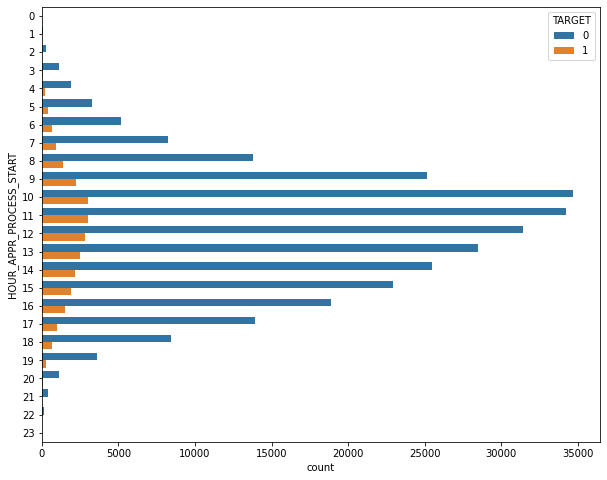

In [29]:
sns.countplot(y= df['HOUR_APPR_PROCESS_START'], hue=df['TARGET'])

Most applications are received between 8am and 6pm. This is expected as, as normally the working hours are during this period. The default rates seem to follow the same trend. Lets find out.

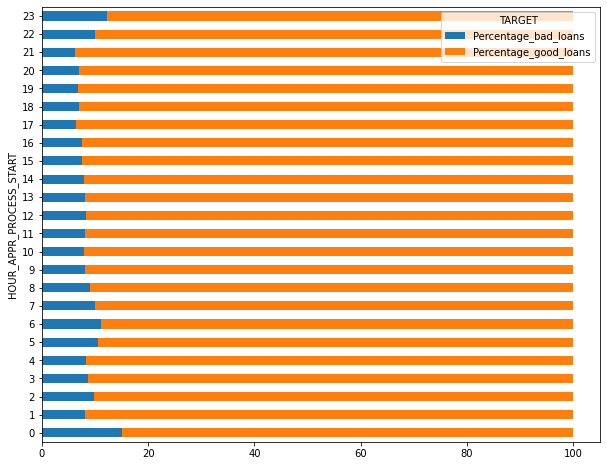

In [30]:
contingency_table = pd.crosstab(df['HOUR_APPR_PROCESS_START'], df['TARGET'])
bad_loans = np.array(contingency_table[1])
good_loans = np.array(contingency_table[0])
total = bad_loans + good_loans
contingency_table['Percentage_bad_loans'] = (bad_loans * 100.0) / total
contingency_table['Percentage_good_loans'] = (good_loans * 100.0)/ total
contingency_table[['Percentage_bad_loans','Percentage_good_loans']].plot(kind='barh', stacked=True)

Interstingly, loans applied at times other than normal working hours, tend to have higher defaults!!

# CITY AND REGION MISMATCH

These columns are used to show if the work address, contact address and home address of the client are the same. This process of verification of facts is called due diligence, and it's an important part of credit appraisal.

In [0]:
 # for these columns, '0' means no difference in address, '1' means addresses are different.
address_verification_columns = ['REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY']

TARGET                           0      1
REG_REGION_NOT_LIVE_REGION               
0                           278462  24392
1                             4224    433


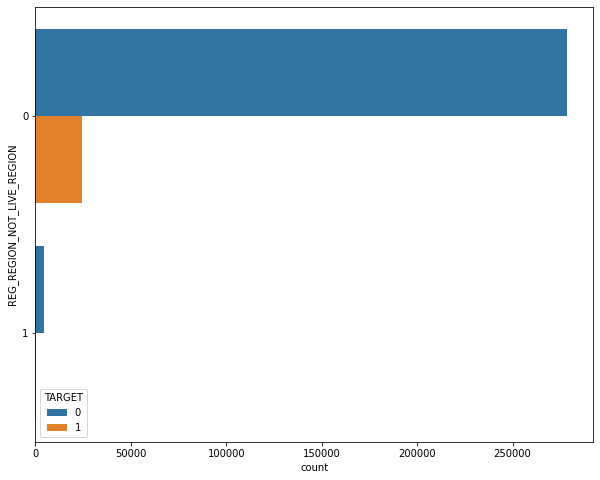

TARGET                           0      1
REG_REGION_NOT_WORK_REGION               
0                           268462  23437
1                            14224   1388


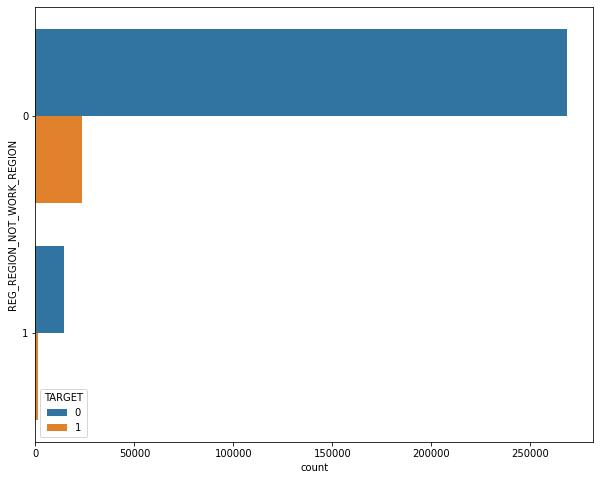

TARGET                            0      1
LIVE_REGION_NOT_WORK_REGION               
0                            271239  23769
1                             11447   1056


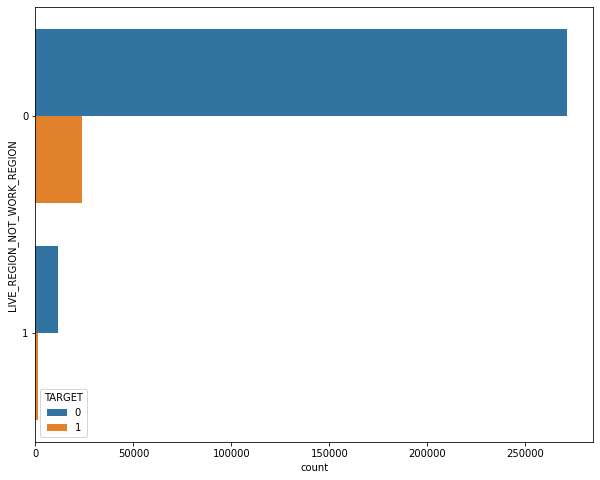

TARGET                       0      1
REG_CITY_NOT_LIVE_CITY               
0                       261586  21886
1                        21100   2939


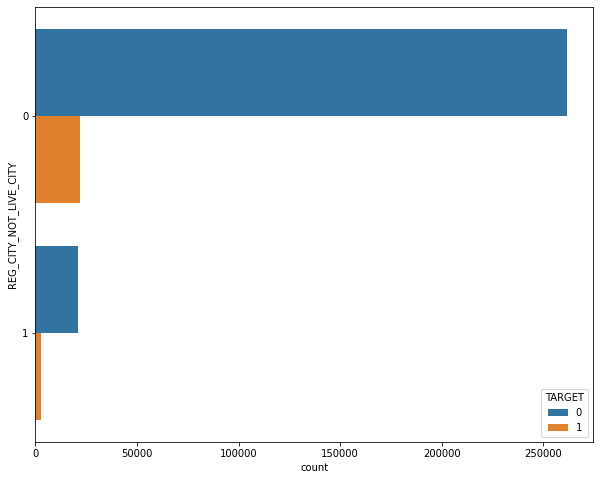

TARGET                       0      1
REG_CITY_NOT_WORK_CITY               
0                       219339  17305
1                        63347   7520


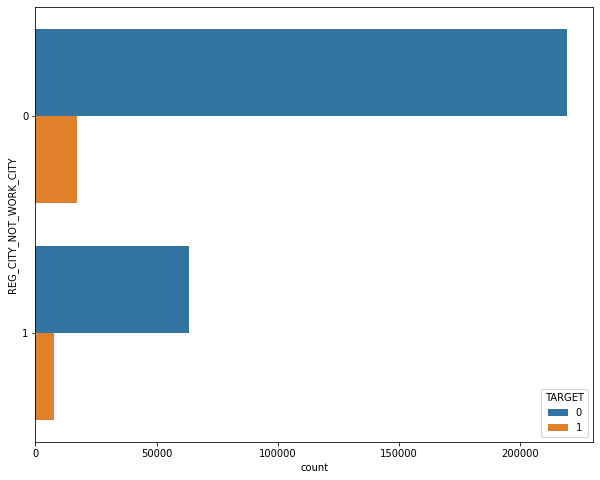

TARGET                        0      1
LIVE_CITY_NOT_WORK_CITY               
0                        232974  19322
1                         49712   5503


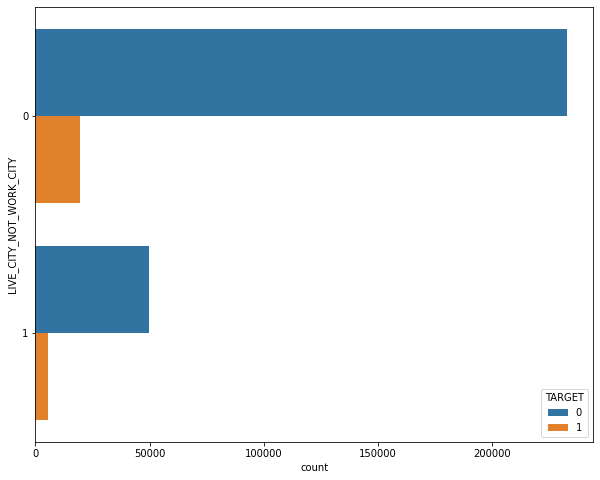

In [32]:
for col in address_verification_columns:
  sns.countplot(y= df[col], hue=df['TARGET'])
  contingency_table = pd.crosstab(df[col], df['TARGET'])
  print(contingency_table)
  plt.show()

It seems most of the clients are working in cities different from their home cities, but in the same region.

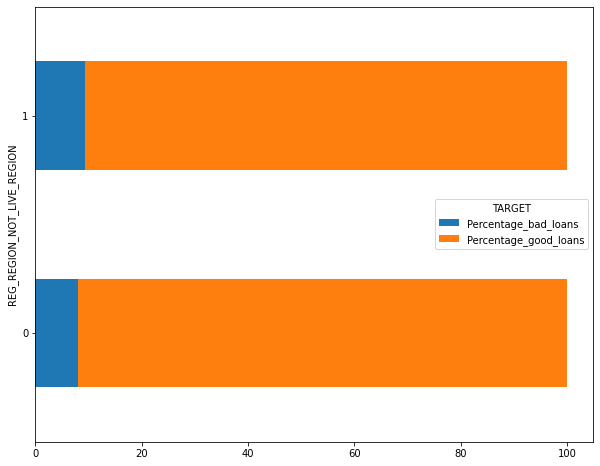

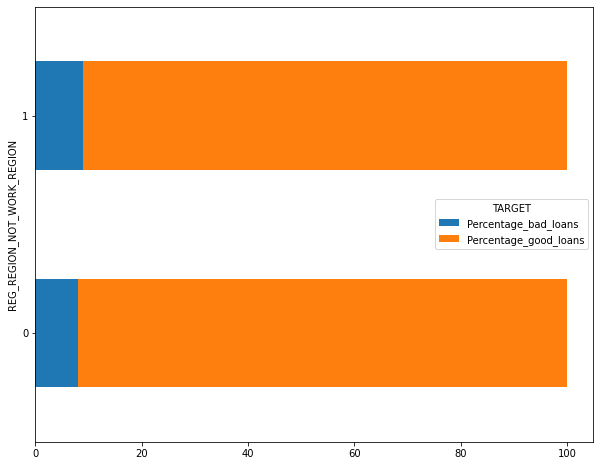

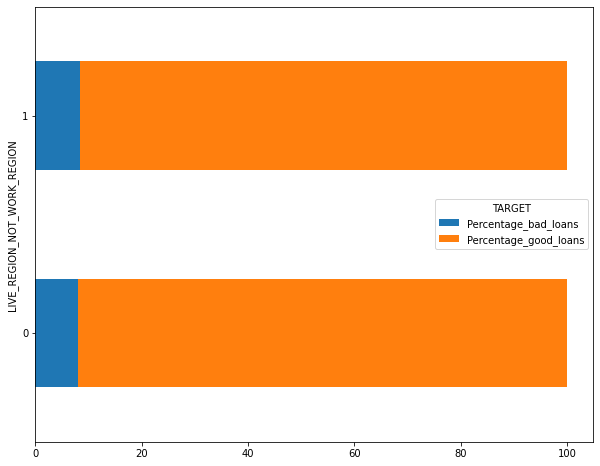

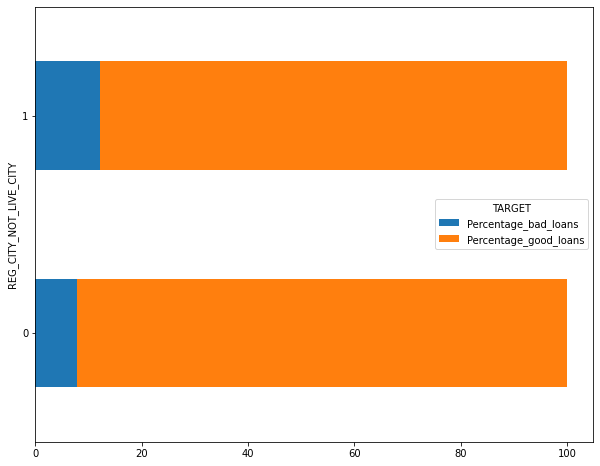

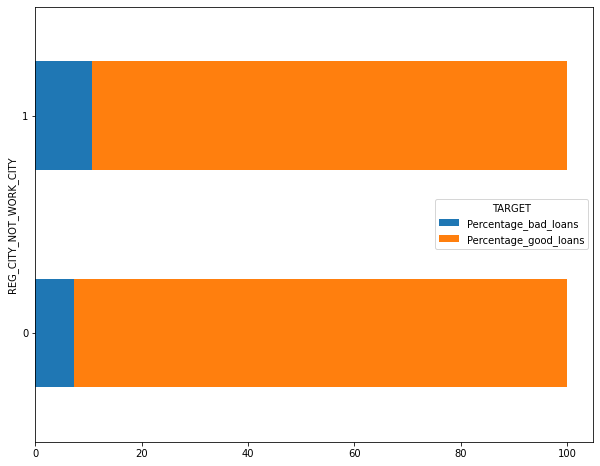

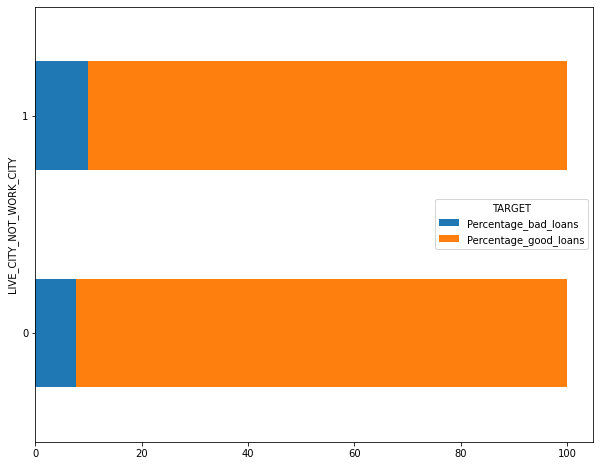

In [33]:
for col in address_verification_columns:
  contingency_table = pd.crosstab(df[col], df['TARGET'])
  bad_loans = np.array(contingency_table[1])
  good_loans = np.array(contingency_table[0])
  total = bad_loans + good_loans
  contingency_table['Percentage_bad_loans'] = (bad_loans * 100.0) / total
  contingency_table['Percentage_good_loans'] = (good_loans * 100.0)/ total
  contingency_table[['Percentage_bad_loans','Percentage_good_loans']].plot(kind='barh', stacked=True)

A difference in REGION does not seem to matter much for default rate. But difference in living city and permanent city seems to increase the defaualt rates in general.

# ORGANIZATION_TYPE

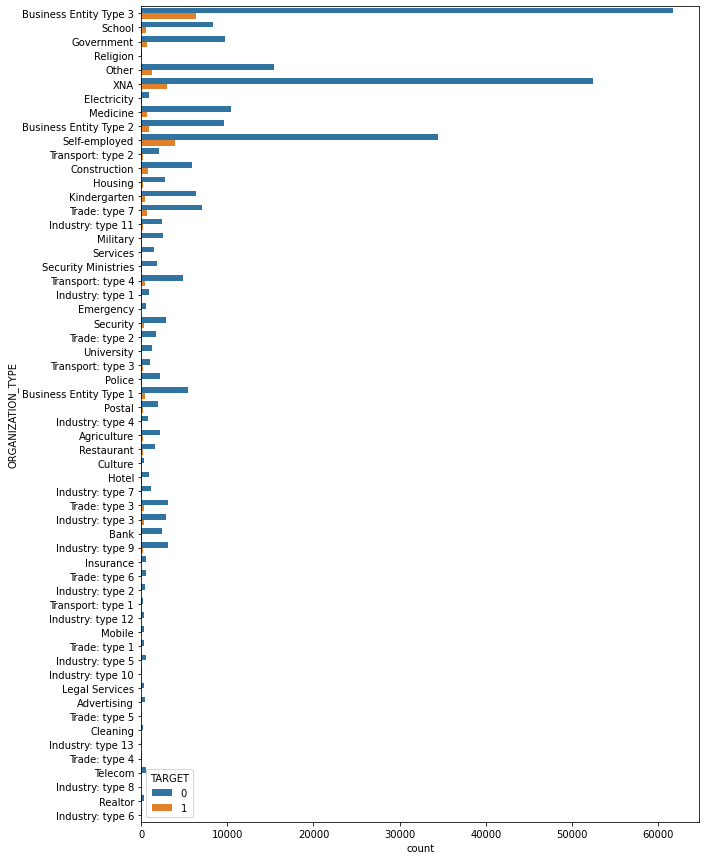

In [35]:
plt.figure(figsize=(10,15))
sns.countplot(y=df['ORGANIZATION_TYPE'], hue=df['TARGET'])

Most applicants are either self-employed or are working in 'Business Entity-Type 3'

<Figure size 720x2880 with 0 Axes>

<Figure size 720x2880 with 0 Axes>

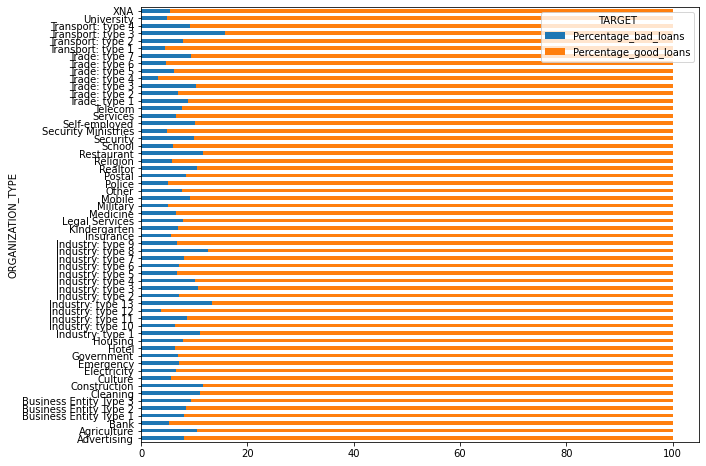

In [40]:
plt.figure(figsize=(10,40))
contingency_table = pd.crosstab(df['ORGANIZATION_TYPE'], df['TARGET'])
bad_loans = np.array(contingency_table[1])
good_loans = np.array(contingency_table[0])
total = bad_loans + good_loans
contingency_table['Percentage_bad_loans'] = (bad_loans * 100.0) / total
contingency_table['Percentage_good_loans'] = (good_loans * 100.0)/ total
contingency_table[['Percentage_bad_loans','Percentage_good_loans']].plot(kind='barh', stacked=True)

There is wide variation in the default rates by organization type. We cannot ascertain applicants from which industries are most prone to defaults. We will try to analyze this column further while modelling.

# DOCUMENTS PROVIDED BY BORROWERS


This group of columns have binary values (1 for yes, 0 for no) for whether the borrower had provided a given document during aplication. For security reasons, we are not provided the exact names of the documents.

In [0]:
document_columns = ['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
                    'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
                    'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16',
                    'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']

Lets plot all these columns and see if there is something interesting.

TARGET                0      1
FLAG_DOCUMENT_2               
0                282677  24821
1                     9      4


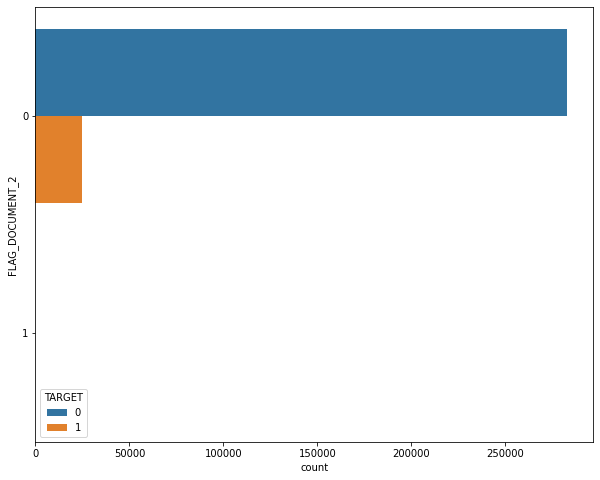

TARGET                0      1
FLAG_DOCUMENT_3               
0                 83658   5513
1                199028  19312


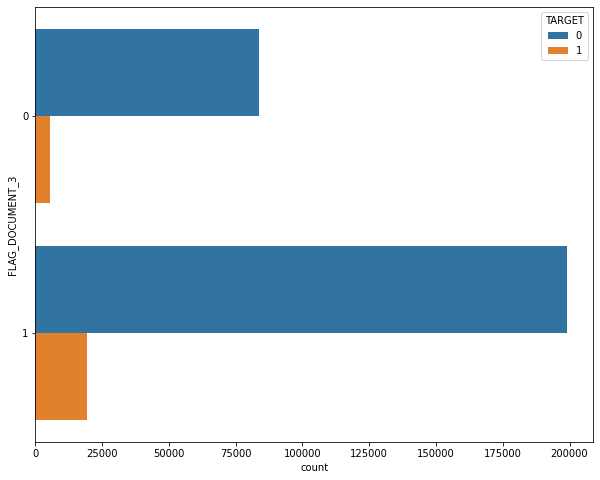

TARGET                0      1
FLAG_DOCUMENT_4               
0                282661  24825
1                    25      0


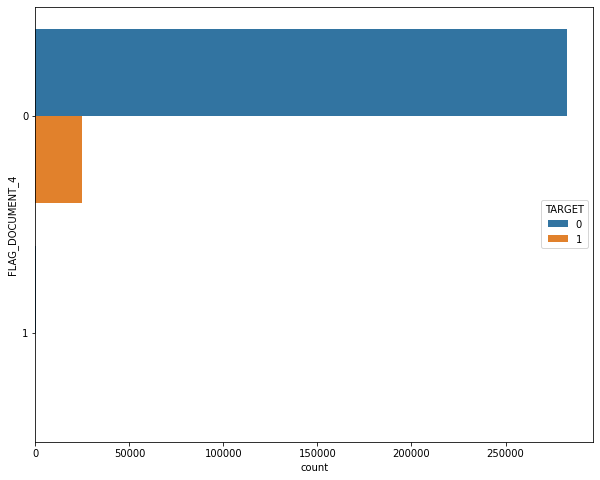

TARGET                0      1
FLAG_DOCUMENT_5               
0                278410  24453
1                  4276    372


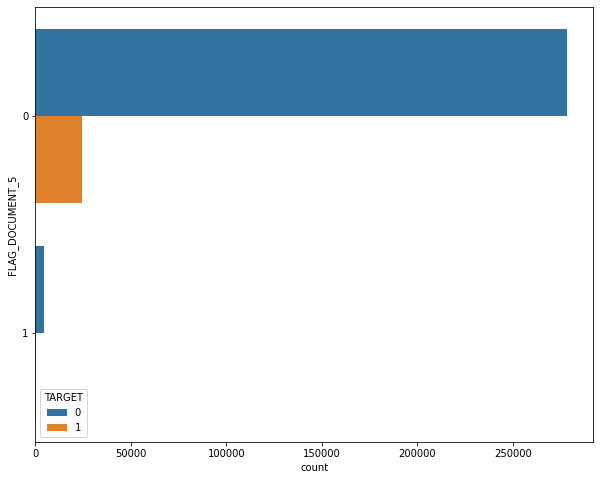

TARGET                0      1
FLAG_DOCUMENT_6               
0                257115  23318
1                 25571   1507


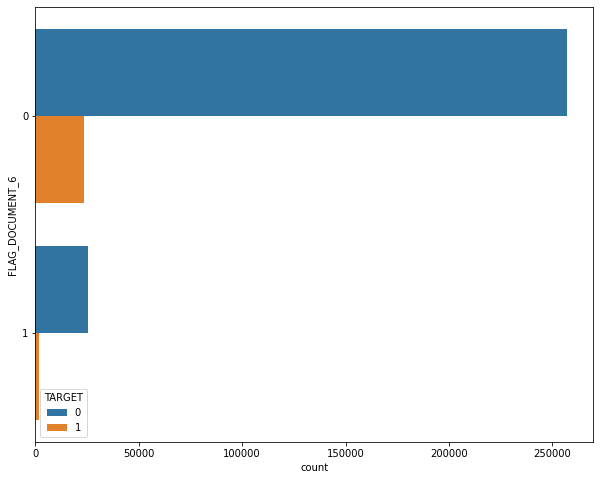

TARGET                0      1
FLAG_DOCUMENT_7               
0                282630  24822
1                    56      3


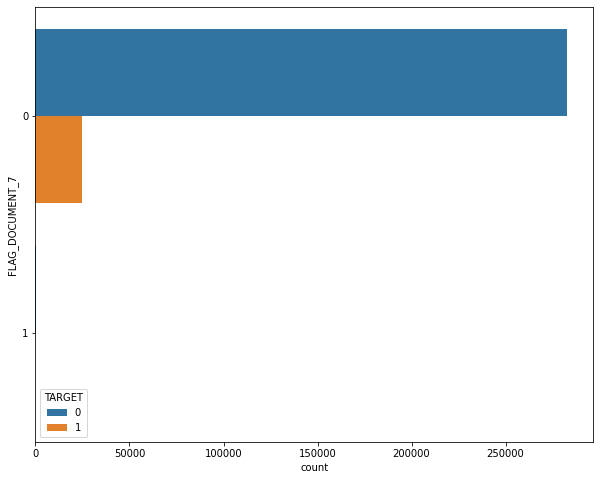

TARGET                0      1
FLAG_DOCUMENT_8               
0                259498  22989
1                 23188   1836


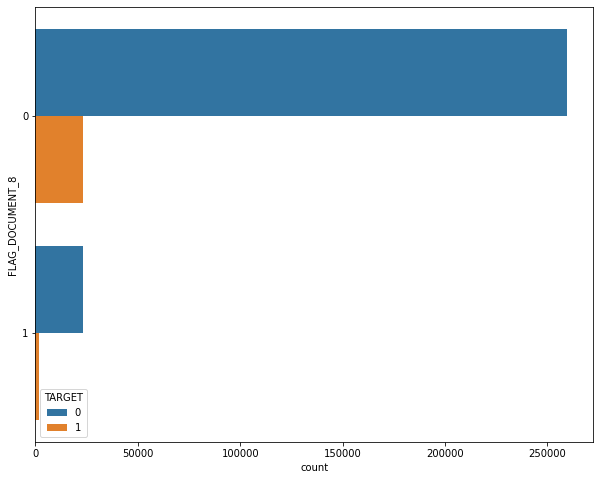

TARGET                0      1
FLAG_DOCUMENT_9               
0                281562  24751
1                  1124     74


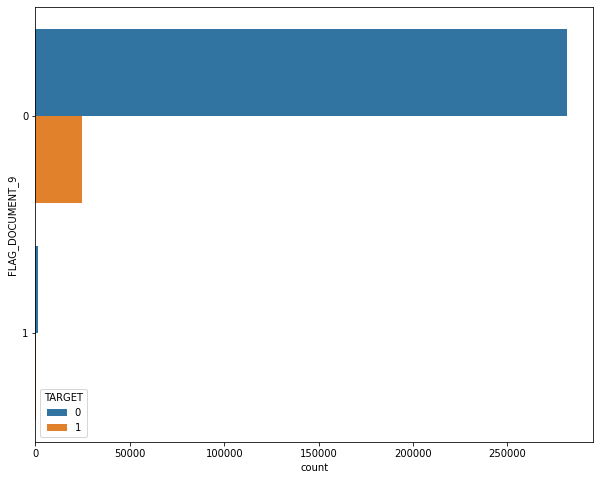

TARGET                 0      1
FLAG_DOCUMENT_10               
0                 282679  24825
1                      7      0


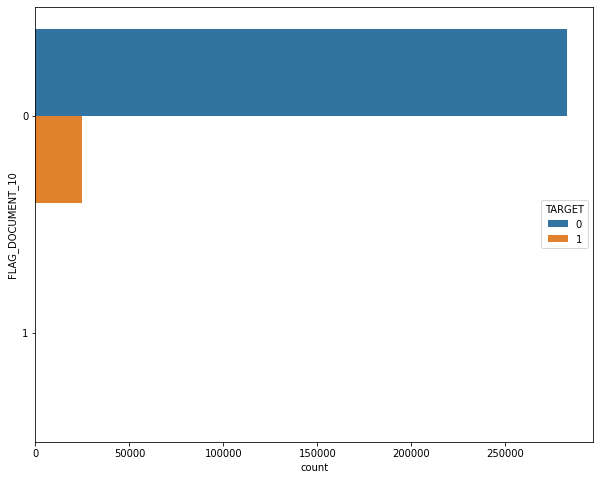

TARGET                 0      1
FLAG_DOCUMENT_11               
0                 281558  24750
1                   1128     75


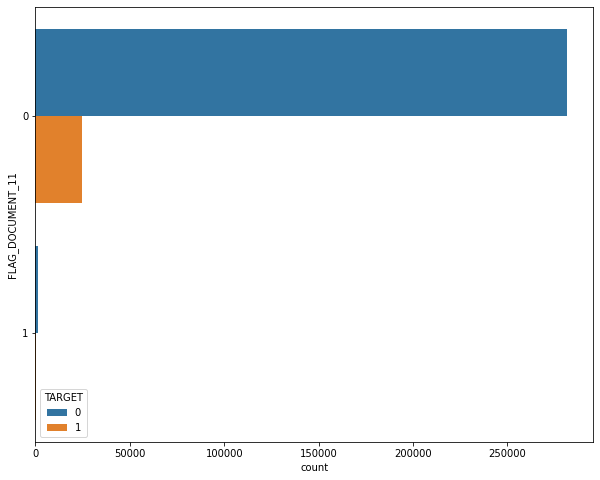

TARGET                 0      1
FLAG_DOCUMENT_12               
0                 282684  24825
1                      2      0


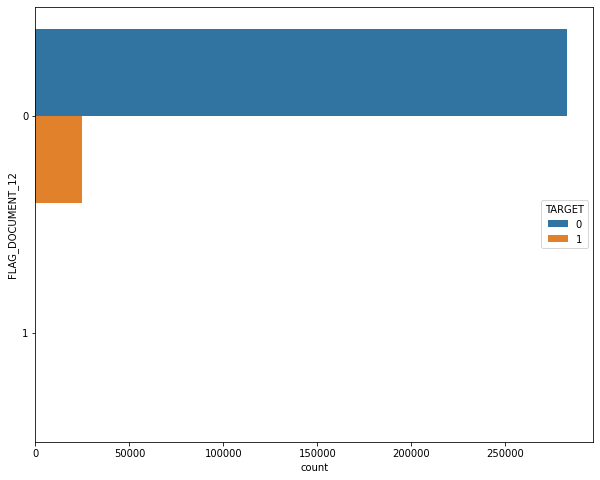

TARGET                 0      1
FLAG_DOCUMENT_13               
0                 281632  24795
1                   1054     30


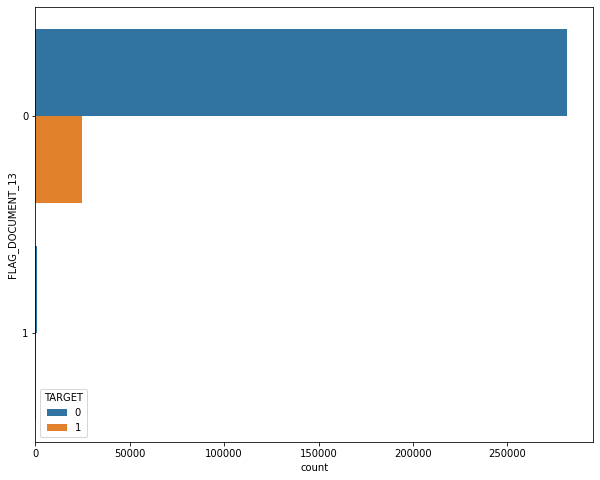

TARGET                 0      1
FLAG_DOCUMENT_14               
0                 281813  24795
1                    873     30


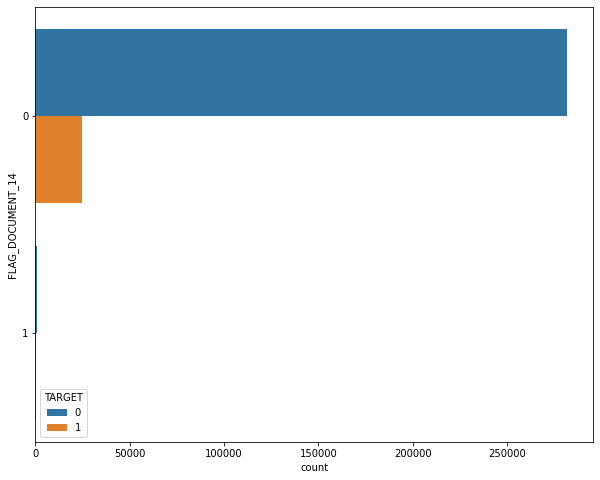

TARGET                 0      1
FLAG_DOCUMENT_15               
0                 282325  24814
1                    361     11


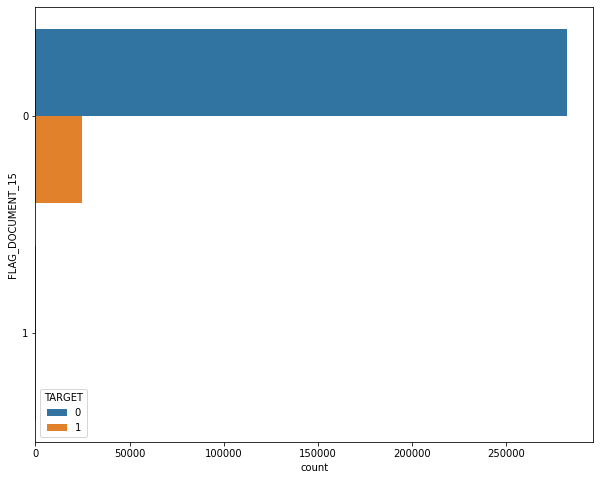

TARGET                 0      1
FLAG_DOCUMENT_16               
0                 279783  24675
1                   2903    150


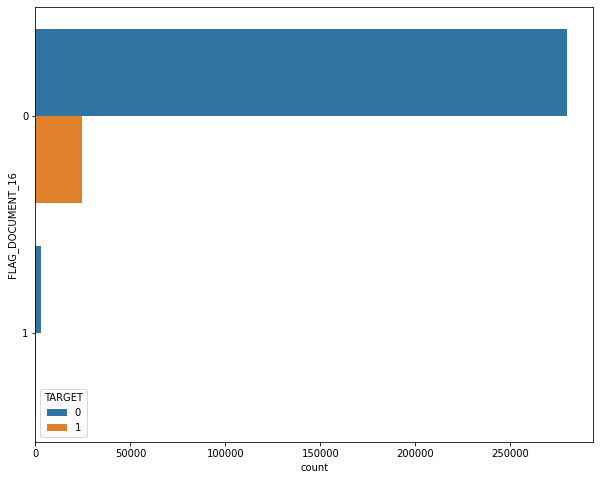

TARGET                 0      1
FLAG_DOCUMENT_17               
0                 282606  24823
1                     80      2


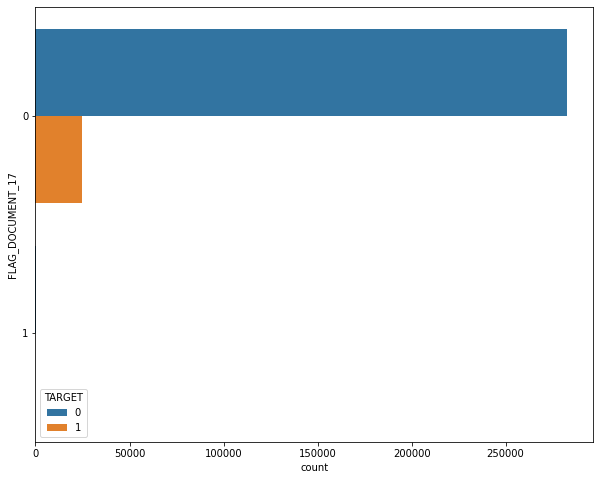

TARGET                 0      1
FLAG_DOCUMENT_18               
0                 280328  24683
1                   2358    142


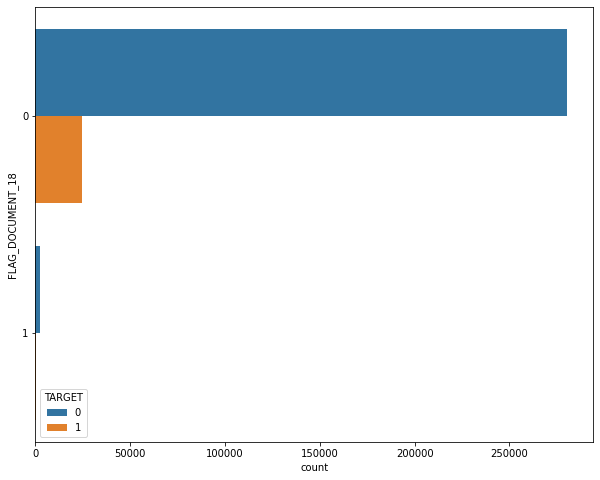

TARGET                 0      1
FLAG_DOCUMENT_19               
0                 282515  24813
1                    171     12


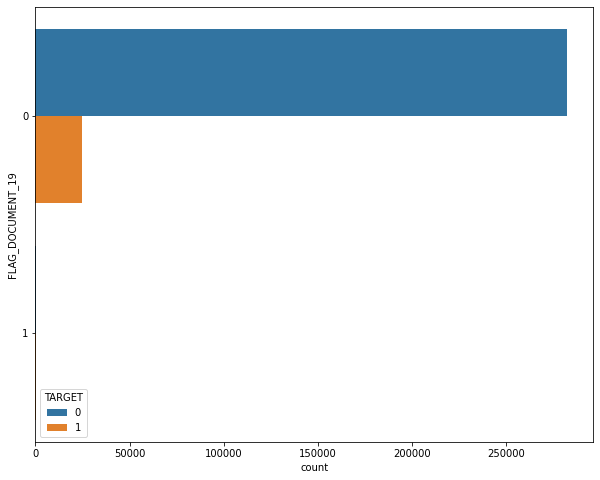

TARGET                 0      1
FLAG_DOCUMENT_20               
0                 282543  24812
1                    143     13


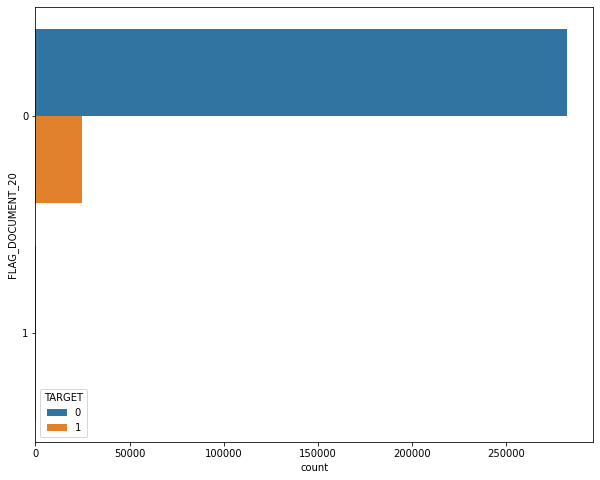

TARGET                 0      1
FLAG_DOCUMENT_21               
0                 282597  24811
1                     89     14


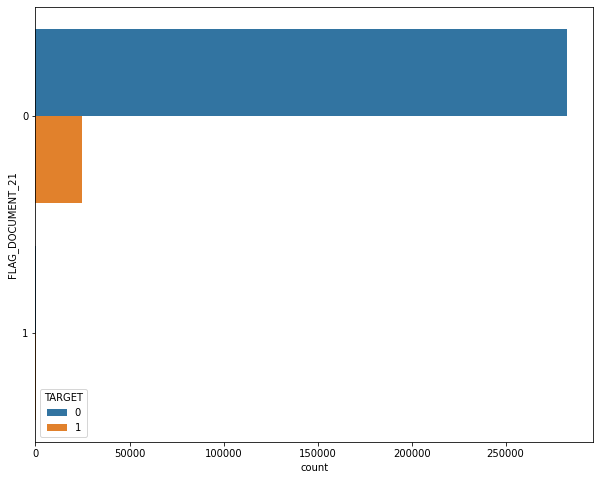

In [0]:
for col in document_columns:
  sns.countplot(y= df[col], hue=df['TARGET'])
  contingency_table = pd.crosstab(df[col], df['TARGET'])
  print(contingency_table)
  plt.show()

It looks that most of the borrowers did not provide a majority of the documents. But still, they have provided loans.
Documents 3, 6 and 8 seem to be important because a relatively larger number of borrowers have provided these documents.

# Ratings by external agencies

The score provided by an external rating agency to the credibility of the client. For example, FICO ratings. The scores range from 0 to 1. In India, we have its equivalent, the CIBIL score.

*Its important to note that external rating agencies use their own mechanisms of evaluating the credibility of a client. Hence, this score represents the overall credit-worthiness of the client. Hence, we are analysing these columns at the end.*

Average of rating-1 for defaulters= 0.3869681258823662
Average of rating-1 for non-defaulters= 0.5114612439213994


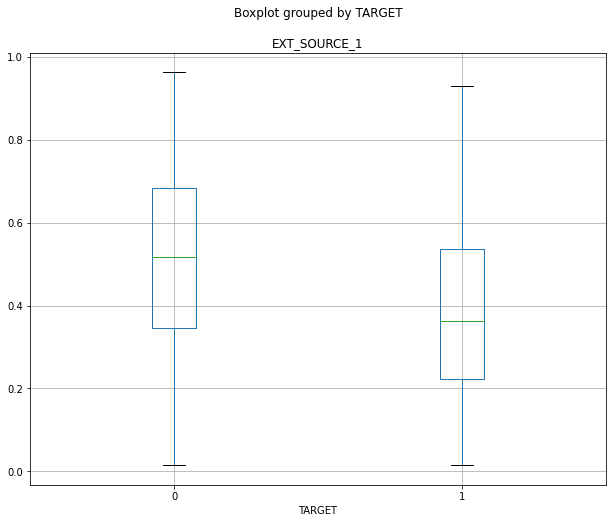

In [55]:
# External rating 1
df.boxplot(column= 'EXT_SOURCE_1', by='TARGET')
print("Average of rating-1 for defaulters=", df_bad['EXT_SOURCE_1'].mean())
print("Average of rating-1 for non-defaulters=", df_good['EXT_SOURCE_1'].mean())

As we should expect, defaulters have got a lower median rating in general. Average ratings of non-defaulters is almost 60% higher than that for defaulters.

Average score of defaulters, by external agaency 2 =  0.4109349069691106
Average score of non-defaulters, by external agaency 2 =  0.5234786690184261


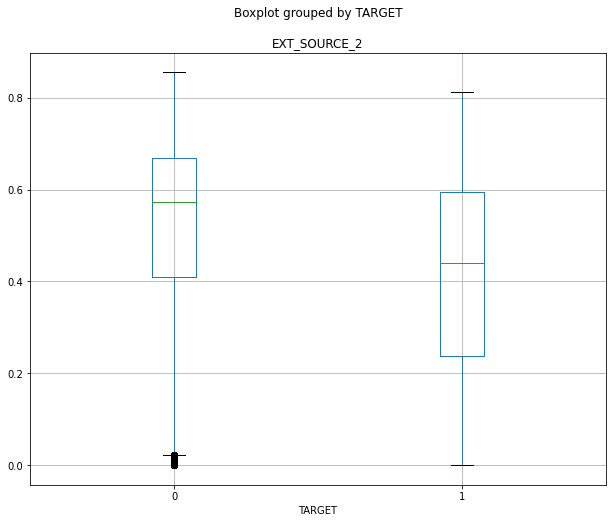

In [51]:
# External rating 2
df.boxplot(column= 'EXT_SOURCE_2', by='TARGET')
print("Average of rating-2 for defaulters = ", df_bad['EXT_SOURCE_2'].mean())
print("Average of rating-2 for non-defaulters= ", df_good['EXT_SOURCE_2'].mean())

In scores of agency 2, defaulters and non-defaulters have got better scores in general, compared to agency 1.

Average of rating-3 for defaulters =  0.39071659090048283
Average of rating-3 for non-defaulters =  0.5209689589376003


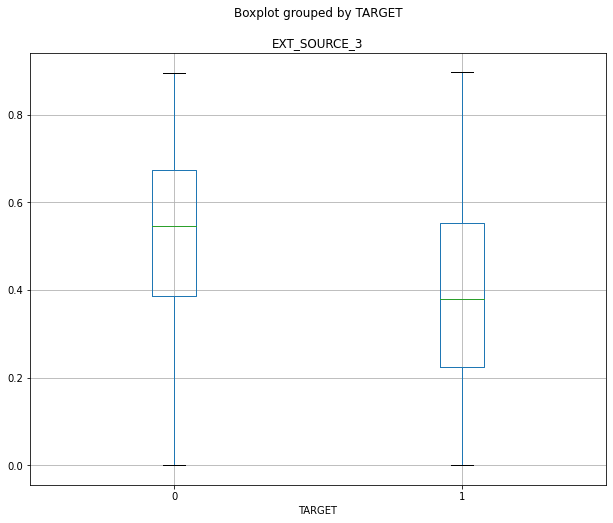

In [53]:
# External rating 3
df.boxplot(column= 'EXT_SOURCE_3', by='TARGET')
print("Average of rating-3 for defaulters = ", df_bad['EXT_SOURCE_3'].mean())
print("Average of rating-3 for non-defaulters = ", df_good['EXT_SOURCE_3'].mean())

# END